# Capstone 2 Modeling (day)

**The Data Science Method**  

1.   Problem Identification 

2.   Data Wrangling 
  * Data Collection 
   * Data Organization
  * Data Definition 
  * Data Cleaning
 
3.   Exploratory Data Analysis
 * Build data profile tables and plots
        - Outliers & Anomalies
 * Explore data relationships
 * Identification and creation of features

4.   Pre-processing and Training Data Development
  * Create dummy or indicator features for categorical variables
  * Standardize the magnitude of numeric features
  * Split into testing and training datasets
  * Apply scaler to the testing set
  
5.   **Modeling**
  * Fit Models with Training Data Set
  * Review Model Outcomes — Iterate over additional models as needed.
  * Identify the Final Model

6.   Documentation
  * Review the Results
  * Present and share your findings - storytelling
  * Finalize Code 
  * Finalize Documentation

## Data Collection

In [57]:
#load python packages
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tbats import BATS, TBATS
from IPython.display import Image
%matplotlib inline

In [2]:
# load the csv files in data/processed folder
df2 = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\df24.csv', index_col='Date')
df6 = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\df2016.csv', index_col='Date')
df7 = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\df2017.csv', index_col='Date')
# change indexes to time series
df2.index = pd.to_datetime(df2.index)
df6.index = pd.to_datetime(df6.index)
df7.index = pd.to_datetime(df7.index)
# set the index frequency
df2.index.freq="D"
df6.index.freq="D"
df7.index.freq="D"
df2.head()

11:00:00  12:00:00  13:00:00  14:00:00  15:00:00  16:00:00  \
Date                                                                     
2016-01-04     16.39     36.27     78.68     51.44     57.70    148.93   
2016-01-05     22.45     27.75      7.25     30.64    100.67    149.72   
2016-01-06     33.59     41.48    111.56     92.00     94.83     94.27   
2016-01-07      8.40     23.30     54.49     42.28    116.13    101.65   
2016-01-08     27.25     86.00     48.34     65.21    186.20    158.67   

            17:00:00  18:00:00  19:00:00  20:00:00  21:00:00  22:00:00  \
Date                                                                     
2016-01-04     74.55     50.34     56.02     79.35     58.34     31.68   
2016-01-05     43.14     68.53     93.65     75.90     27.45     31.70   
2016-01-06     45.26     70.35     57.22     52.53     46.87     49.12   
2016-01-07     52.04     47.96    128.00     77.01     91.02     75.42   
2016-01-08     93.76    117.30    143.23    105.70    182.96     89.71   

            23:00:00    Daily  
Date                           
2016-01-04      0.00   739.69  
2016-01-05      0.00   678.85  
2016-01-06      0.00   789.08  
2016-01-07      0.00   817.70  
2016-01-08     64.12  1368.45

In [3]:
# let's check the monthly sum to determine how many months to train/test and forecast
monthly_df6 = df6.Daily.groupby(df6.index.month).sum()
monthly_df7 = df7.Daily.groupby(df7.index.month).sum()
display(monthly_df6)
monthly_df7

Date
1     29670.498889
2     37205.323704
3     34261.162406
4     39669.840000
5     40581.600000
6     35244.510000
7     35850.027059
8     36106.890000
9     39045.180000
10    38924.410000
11    35246.587941
12    33431.255584
Name: Daily, dtype: float64

Date
1     31628.213333
2     30722.160000
3     39216.192059
4     40090.300000
5     39922.728889
6     35847.533871
7     38372.780000
8     38483.515021
9     44649.233559
10    42940.750000
11    34170.149197
12    34242.660342
Name: Daily, dtype: float64

We will use 9/1/2017 until end of 2017 as testing date, while forecasting the whole 2018 to compare with baseline, which is the average of 2016 and 2017's daily sales.

In [4]:
# make a dataframe that's the average of 2016 and 2017, we will use it as a baseline comparsion for 2018
bl_df = pd.concat([df6.Daily.reset_index(), df7.Daily.reset_index()], axis=1, ignore_index=True)
bl_df.columns=['2016', 'sales2016', '2017', 'sales2017']
# define an avg function to get the avg of 2 inputs, then we can use it to df.apply lambda and get the baseline
def avg(one, two):
    return (one + two)/2
bl_df['baseline'] = bl_df.apply(lambda x: avg(x['sales2016'], x['sales2017']), axis=1)
#set index
bl_df.index = pd.date_range('2018-01-01', periods=364, freq='D')
#remove unnecessary columns
bl_df = bl_df.baseline
# save the dataframe to csv file
bl_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\baseline.csv',
                      index=True)
bl_df

2018-01-01     930.530000
2018-01-02     681.100000
2018-01-03     794.630000
2018-01-04     906.870000
2018-01-05    1296.835000
                 ...     
2018-12-26    1003.790000
2018-12-27    1173.920000
2018-12-28    1067.700000
2018-12-29    1219.160100
2018-12-30    1191.677308
Freq: D, Name: baseline, Length: 364, dtype: float64

# Correlograms

Autocorrelogram & Partial Autocorrelogram is useful that to estimate each models parameters.

In [5]:
#train_test_split and forecast dates
train_start,train_end = '2016-01-04','2017-08-31'
test_start,test_end = '2017-09-01','2017-12-31'
forecast_start, forecast_end = '2018-01-01','2018-12-30'
train = df2['Daily'][train_start:train_end].dropna()
test = df2['Daily'][test_start:test_end].dropna()
baseline = bl_df

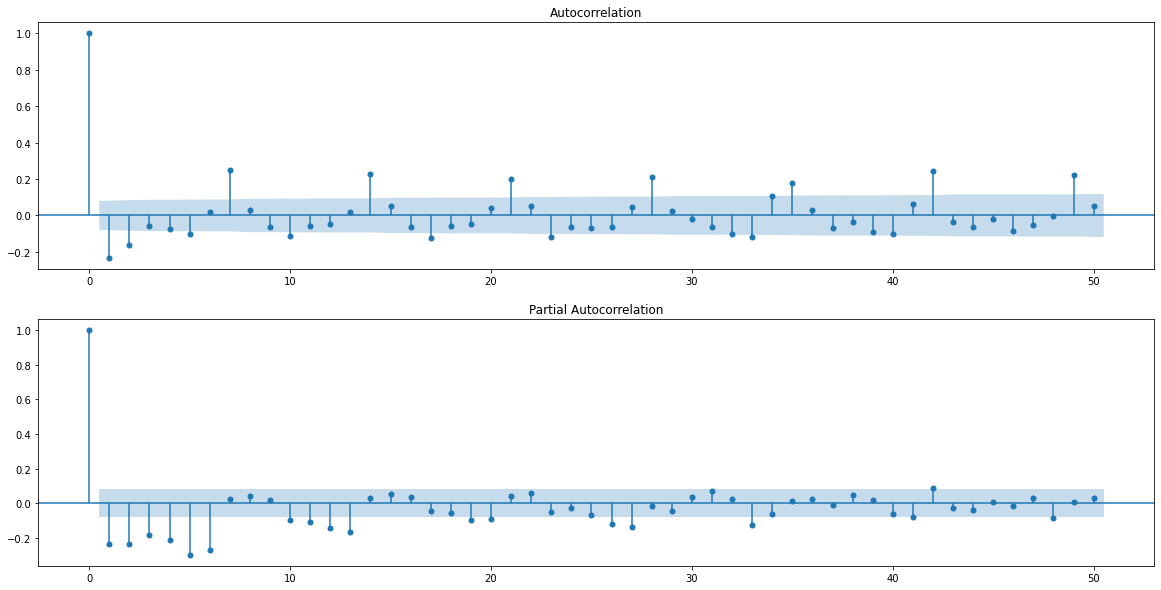

In [6]:
#we use train.diff()(differenced data), because this time series is unit root process.
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(train.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(train.diff().dropna(), lags=50, ax=ax[1])
plt.show()

From Autocorrelation, we can see that there's a recurring pattern every 7 periods, indicating a weekly pattern exists; hence p=7.
Since our time series data is stationary, no differencing is needed, so d=0.

# ARIMA Modeling
We will use SARIMAX but with seasonal_order = (0,0,0,0), so it has same result as ARIMA

In [7]:
# do a sample run to check and see if the dates are the dates we are looking for
arima = sm.tsa.statespace.SARIMAX(train, order=(0,0,0), freq='D', seasonal_order=(0,0,0,0), 
                                  enforce_stationarity=False, enforce_invertibility=False,).fit()
#get the prediction and forecast
pred = arima.predict(train_end,test_end)[1:]
print(pred)
fore = arima.predict(test_end, forecast_end)[1:]
print(fore)

2017-09-01    0.0
2017-09-02    0.0
2017-09-03    0.0
2017-09-04    0.0
2017-09-05    0.0
             ... 
2017-12-27    0.0
2017-12-28    0.0
2017-12-29    0.0
2017-12-30    0.0
2017-12-31    0.0
Freq: D, Length: 122, dtype: float64
2018-01-01    0.0
2018-01-02    0.0
2018-01-03    0.0
2018-01-04    0.0
2018-01-05    0.0
             ... 
2018-12-26    0.0
2018-12-27    0.0
2018-12-28    0.0
2018-12-29    0.0
2018-12-30    0.0
Freq: D, Length: 364, dtype: float64


In [ ]:
# ARIMA gridsearch and metric score recording
#Grid search method for best parameters based on MSE, smape, and AIC of test and forecast
#create empty lists to store values
model_list = []
p_list = []
d_list = []
q_list = []
MSE_list = []
MAE_list = []
AIC_list = []
ForeMSE_list = []
ForeMAE_list = []

#iternation
for p in range(8):
    for d in [0, 1]:
        for q in range(8):
            #fit the model
            arima = sm.tsa.statespace.SARIMAX(train, order=(p,d,q), freq='D', seasonal_order=(0,0,0,0), 
                                              enforce_stationarity=False, enforce_invertibility=False,).fit()
            #get the prediction & future forecast for 2018
            pred = arima.predict(train_end,test_end)[1:]
            fore = arima.predict(test_end, forecast_end)[1:]

            #append the values (calculate)
            model_list.append('ARIMA')
            p_list.append(p)
            d_list.append(d)
            q_list.append(q)
            MSE_list.append(mean_squared_error(test, pred))
            MAE_list.append(mean_absolute_error(test, pred))
            AIC_list.append(arima.aic)
            ForeMSE_list.append(mean_squared_error(baseline,fore))
            ForeMAE_list.append(mean_absolute_error(baseline,fore))

#create a dict to store the key:values then change to dataframe for easier/cleaner access
arima_score_dict = {
    'model':model_list,
    'p': p_list,
    'd': d_list,
    'q': q_list,
    'MSE': MSE_list,
    'MAE': MAE_list,
    'AIC': AIC_list,
    'ForeMSE': ForeMSE_list,
    'ForeMAE': ForeMAE_list,
}
arima_score_df = pd.DataFrame.from_dict(arima_score_dict)
#save the dataframe to csv so we can load it next time instead of grid search everytime we restart
arima_score_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\arima_gridsearch.csv',
                      index=False)

In [ ]:
# Auto_arima to search for best params
auto_arima(train, exogenous=None, 
           start_p=6, d=None, start_q=0, max_p=10, max_d=1, max_q=10, # grid search for order params
           start_P=0, D=None, start_Q=0, max_P=0, max_D=0, max_Q=0, m=0, #grid search for seasonal order params, seaonal=True
           max_order=21, seasonal=False, stationary=True, information_criterion='aic', suppress_warnings=True) 
#maxorder = allowed sum of p and q, since an year has 12 months, so we'll have 11 as max for p, 10 for q
#data already stationary so stationary=True

#**Result order=(10,0,0)**

In [ ]:
# ARMA order select to search for best params
resDiff = sm.tsa.arma_order_select_ic(train, max_ar=10, max_ma=10, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

#**Result p=8, q=8, d has to be 0, since it's designed for ARMA**

In [ ]:
# Recording the scores from auto arima and order select
model_list = []
p_list = []
d_list = []
q_list = []
MSE_list = []
MAE_list = []
AIC_list = []
ForeMSE_list = []
ForeMAE_list = []

#iternation
for p in [8,10]:
    for d in [0]:
        for q in [0,8]:
            #fit the model
            arima = sm.tsa.statespace.SARIMAX(train, order=(p,0,q), freq='D', seasonal_order=(0,0,0,0), 
                                              enforce_stationarity=False, enforce_invertibility=False,).fit()
            #get the prediction & future forecast for 2018
            pred = arima.predict(train_end,test_end)[1:]
            fore = arima.predict(test_end, forecast_end)[1:]

            #append the values (calculate)
            model_list.append('ARIMAX')
            p_list.append(p)
            d_list.append(d)
            q_list.append(q)
            MSE_list.append(mean_squared_error(test, pred))
            MAE_list.append(mean_absolute_error(test, pred))
            AIC_list.append(arima.aic)
            ForeMSE_list.append(mean_squared_error(baseline,fore))
            ForeMAE_list.append(mean_absolute_error(baseline,fore))

#create a dict to store the key:values then change to dataframe for easier/cleaner access
arima_score_dict = {
    'p': p_list,
    'd': d_list,
    'q': q_list,
    'MSE': MSE_list,
    'MAE': MAE_list,
    'AIC': AIC_list,
    'ForeMSE': ForeMSE_list,
    'ForeMAE': ForeMAE_list,
}
arima_score_df = pd.DataFrame.from_dict(arima_score_dict)
#save the dataframe to csv so we can load it next time instead of grid search everytime we restart
arima_score_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\auto_arima_order_select.csv',
                      index=False)

In [8]:
#need to change working directory to figure so we can save the figures in its folder
path="C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\figures"
os.chdir(path)

In [9]:
# create a function to take in the order parameters for ARIMA, fit, plot diagnostics, display metrics scores,
# plot the test vs predict and save all figures
def ARIMA101(p, d, q):
    #fit the model with given params
    arima = sm.tsa.statespace.SARIMAX(train, order=(p,d,q), seasonal_order=(0,0,0,0), freq='D',
                                      enforce_stationarity=False, enforce_invertibility=False,).fit()
    #get the diagnostics for the model
    arima.plot_diagnostics(figsize=(15, 12))
    plt.savefig('arima{}_diagnostics.png'.format(str(p)+str(d)+str(q)))
    plt.show()
    #predict using the model
    pred = arima.predict(train_end,test_end)[1:]
    fore = arima.predict(test_end,forecast_end)[1:]
    #print the current model's metric scores
    print('ARIMA{} model test MSE:'.format(str(p)+str(d)+str(q)), mean_squared_error(test,pred))
    print('ARIMA{} model test MAE:'.format(str(p)+str(d)+str(q)), mean_absolute_error(test,pred))
    print('ARIMA{} model AIC:'.format(str(p)+str(d)+str(q)), arima.aic)
    print('ARIMA{} model forecast MSE:'.format(str(p)+str(d)+str(q)), mean_squared_error(baseline,fore))
    print('ARIMA{} model forecast MAE:'.format(str(p)+str(d)+str(q)), mean_absolute_error(baseline,fore))

    #view the plot of test vs pred
    pd.DataFrame({'test':test,'pred':pred, 'baseline':baseline, 'forecast': fore}).plot(figsize=(10, 6))
    plt.suptitle('ARIMA{} test vs prediction & forecast'.format(str(p)+str(d)+str(q)))
    plt.legend(["Test", "Predict", "Baseline", "Forecast"])
    plt.savefig('arima{}_test_pred.png'.format(str(p)+str(d)+str(q)))
    plt.show()
    return

In [10]:
# load and concat the arima metric scores
arima_df = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\arima_gridsearch.csv')
arima_df2 = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\auto_arima_order_select.csv')
arima_dfs = pd.concat([arima_df, arima_df2], ignore_index=True)

In [11]:
# find the top 3 of each scoring category
display(arima_dfs.sort_values('MSE').head(3))
display(arima_dfs.sort_values('MAE').head(3))
display(arima_dfs.sort_values('AIC').head(3))
display(arima_dfs.sort_values('ForeMSE').head(3))
arima_dfs.sort_values('ForeMAE').head(3)

model  p  d  q           MSE         MAE          AIC        ForeMSE  \
84  ARIMA  5  0  4  56829.626466  179.603289  8152.927942  231241.552617   
68  ARIMA  4  0  4  61836.375756  187.922127  8109.478887  180583.026064   
96  ARIMA  6  0  0  62646.299520  195.102267  8182.390450  174484.947090   

       ForeMAE  
84  419.334757  
68  368.793125  
96  357.215893

model  p  d  q           MSE         MAE          AIC        ForeMSE  \
84  ARIMA  5  0  4  56829.626466  179.603289  8152.927942  231241.552617   
68  ARIMA  4  0  4  61836.375756  187.922127  8109.478887  180583.026064   
98  ARIMA  6  0  2  67264.432566  188.438683  8150.271316  488334.961678   

       ForeMAE  
84  419.334757  
68  368.793125  
98  641.654330

model   p  d  q           MSE         MAE          AIC       ForeMSE  \
131  ARIMA  10  0  8  80994.277510  225.060880  8010.731141  41186.082020   
127  ARIMA   7  1  7  81600.114016  229.085354  8023.303576  45572.117917   
129  ARIMA   8  0  8  86396.395890  236.983154  8025.733352  72686.517220   

        ForeMAE  
131  164.234482  
127  174.296090  
129  227.607350

model  p  d  q           MSE         MAE          AIC       ForeMSE  \
126  ARIMA  7  1  6  82700.860481  222.524098  8038.590400  34966.929421   
125  ARIMA  7  1  5  82350.514643  221.577906  8042.803366  35058.929130   
59   ARIMA  3  1  3  78462.712493  220.622860  8110.366953  35846.191049   

        ForeMAE  
126  145.977588  
125  146.219253  
59   150.547041

model  p  d  q           MSE         MAE          AIC       ForeMSE  \
126  ARIMA  7  1  6  82700.860481  222.524098  8038.590400  34966.929421   
125  ARIMA  7  1  5  82350.514643  221.577906  8042.803366  35058.929130   
59   ARIMA  3  1  3  78462.712493  220.622860  8110.366953  35846.191049   

        ForeMAE  
126  145.977588  
125  146.219253  
59   150.547041

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


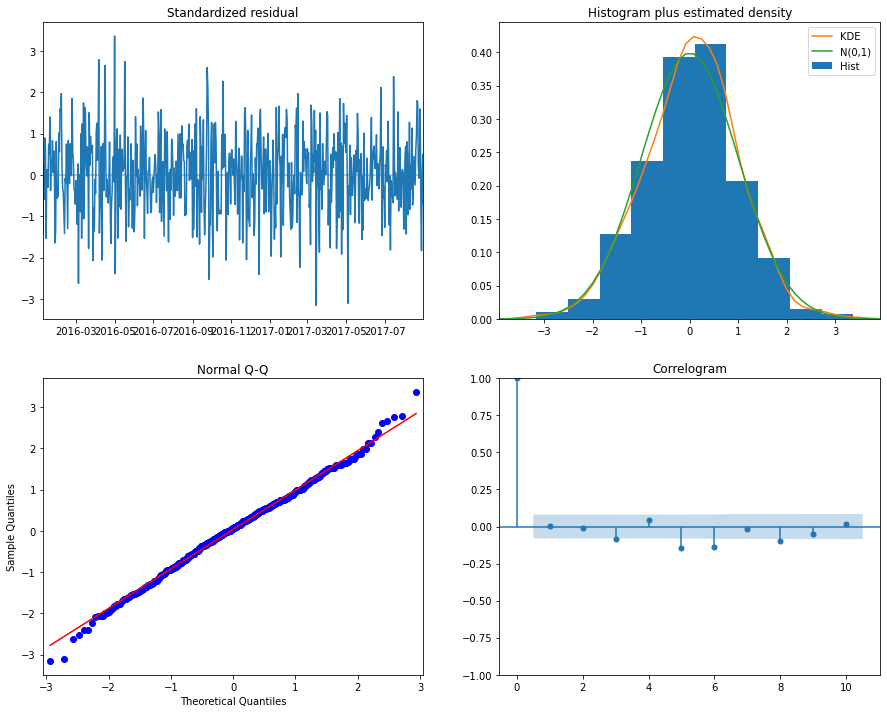

ARIMA504 model test MSE: 56829.626465548456
ARIMA504 model test MAE: 179.6032886724129
ARIMA504 model AIC: 8152.927941745487
ARIMA504 model forecast MSE: 231241.55261686663
ARIMA504 model forecast MAE: 419.3347570031445


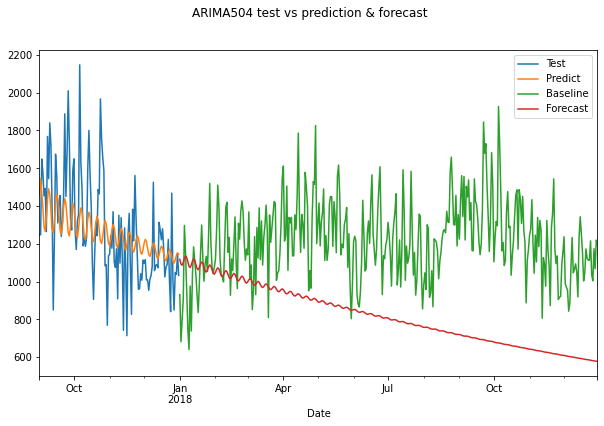

In [12]:
ARIMA101(5,0,4) #lowest MSE and MAE

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

In the top right plot, we see that the KDE line follows pretty close with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). This is also an indication that the residuals are normally distributed.

The residuals over time (top left plot) don’t display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


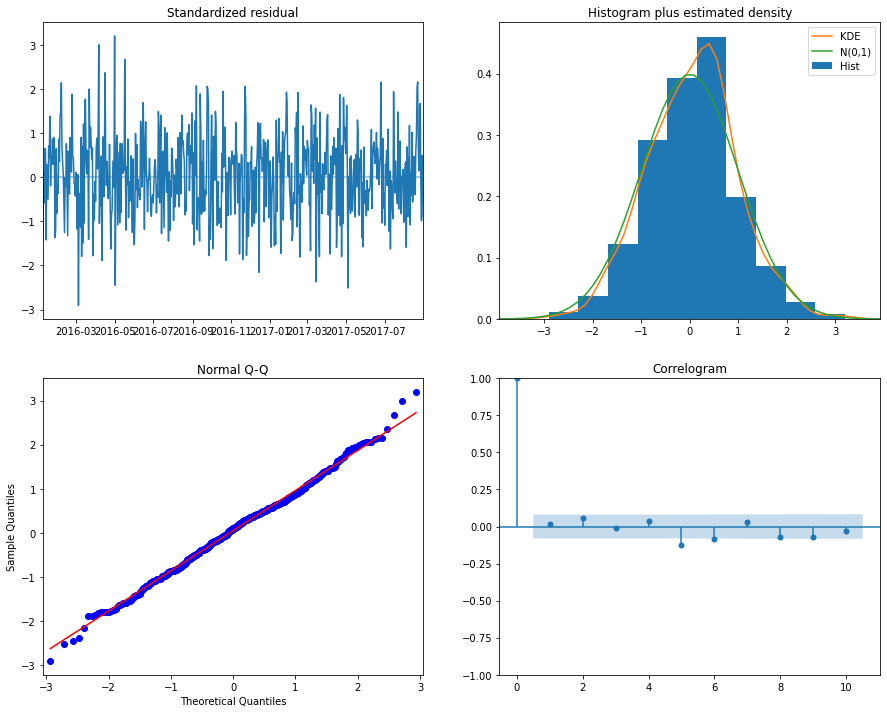

ARIMA404 model test MSE: 61836.375755774265
ARIMA404 model test MAE: 187.9221274993271
ARIMA404 model AIC: 8109.478887365134
ARIMA404 model forecast MSE: 180583.0260638822
ARIMA404 model forecast MAE: 368.79312486353507


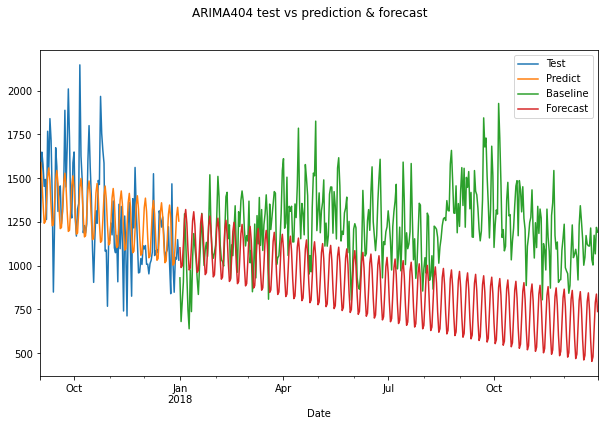

In [13]:
ARIMA101(4,0,4) # even though it's second in place, the ForeMSE is lower than 1st place

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


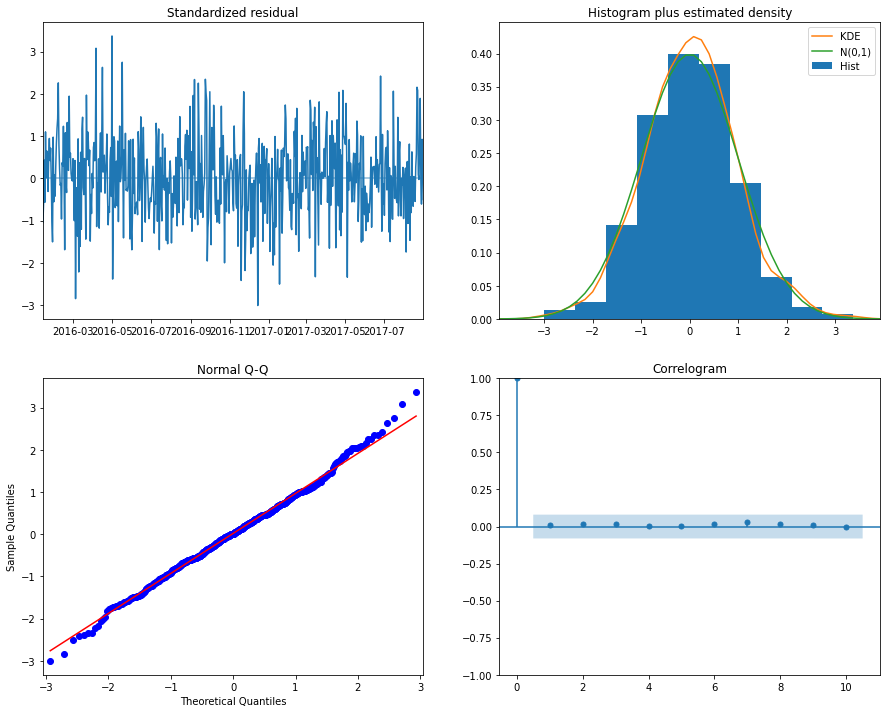

ARIMA1008 model test MSE: 80994.27750632312
ARIMA1008 model test MAE: 225.0608795741459
ARIMA1008 model AIC: 8010.731141038063
ARIMA1008 model forecast MSE: 41186.082017463836
ARIMA1008 model forecast MAE: 164.23448221066363


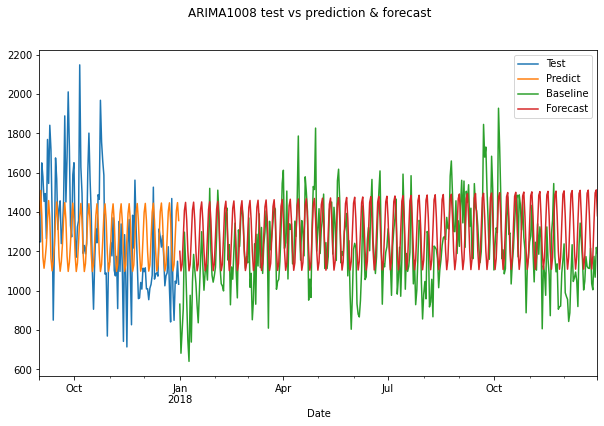

In [14]:
ARIMA101(10,0,8) #lowest AIC

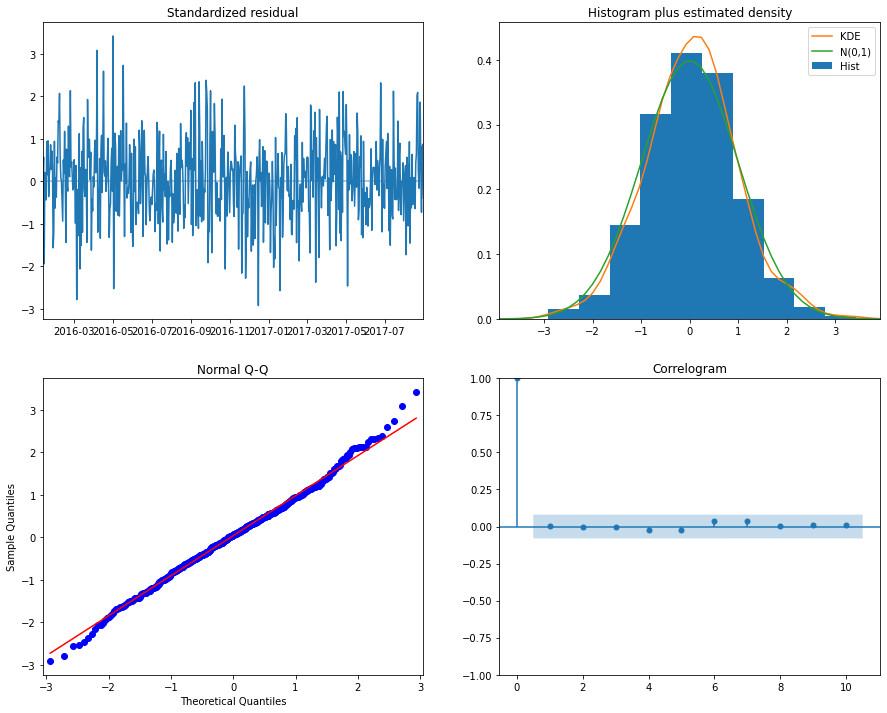

ARIMA716 model test MSE: 82700.8604808647
ARIMA716 model test MAE: 222.524097763027
ARIMA716 model AIC: 8038.59040017368
ARIMA716 model forecast MSE: 34966.92942073181
ARIMA716 model forecast MAE: 145.9775884813462


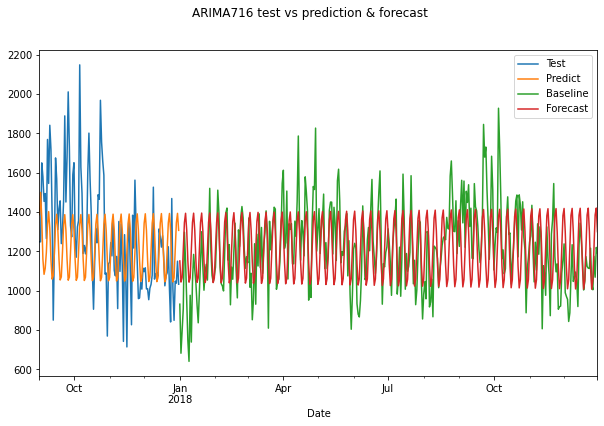

In [15]:
ARIMA101(7,1,6) #best Forecast scores

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


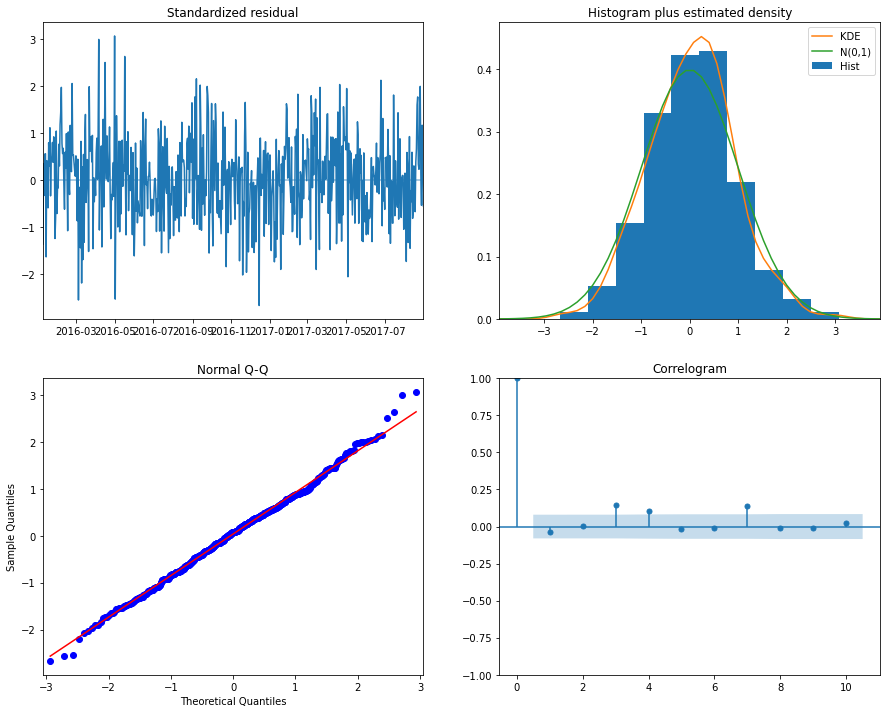

ARIMA313 model test MSE: 78462.71249342342
ARIMA313 model test MAE: 220.62286000732644
ARIMA313 model AIC: 8110.36695330462
ARIMA313 model forecast MSE: 35846.19104929065
ARIMA313 model forecast MAE: 150.54704072194943


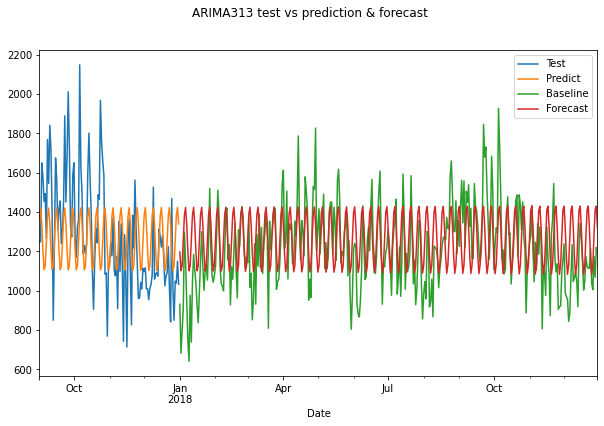

In [16]:
ARIMA101(3,1,3) #3rd in Forecast scores but much better MSE score

Even though the ARIMA can capture the weekly periodicity, it totally failed the yearly seasonality, which we can see obviously by views the forecast vs baseline figures.

# SARIMA
The method is suitable for univariate time series with trend and/or seasonal components.
Let's check and see which parameters from ARIMA gave best result and take the order params from them.

In [ ]:
# SARIMA gridsearch and metric score recording
#Grid search method for best parameters based on MSE, smape, and AIC of test and forecast
#create empty lists to store values
model_list = []
p_list = []
d_list = []
q_list = []
P_list = []
D_list = []
Q_list = []
MSE_list = []
MAE_list = []
AIC_list = []
ForeMSE_list = []
ForeMAE_list = []

#iternation
for p in range(7):
    for d in [0, 1]:
        for q in range(7):
            for P in range(3):
                for D in range(2):
                    for Q in range(3):
                        #fit the model
                        model = sm.tsa.statespace.SARIMAX(train, order=(p,d,q), freq='D', seasonal_order=(P,D,Q,7), 
                                                          enforce_stationarity=False, enforce_invertibility=False,).fit()
                        #get the prediction & future forecast for 2018
                        pred = model.predict(train_end,test_end)[1:]
                        fore = model.predict(test_end, forecast_end)[1:]

                        #append the values (calculate)
                        model_list.append('SARIMA')
                        p_list.append(p)
                        d_list.append(d)
                        q_list.append(q)
                        P_list.append(P)
                        D_list.append(D)
                        Q_list.append(Q)
                        MSE_list.append(mean_squared_error(test, pred))
                        MAE_list.append(mean_absolute_error(test, pred))
                        AIC_list.append(arima.aic)
                        ForeMSE_list.append(mean_squared_error(baseline,fore))
                        ForeMAE_list.append(mean_absolute_error(baseline,fore))

#create a dict to store the key:values then change to dataframe for easier/cleaner access
model_score_dict = {
    'p': p_list,
    'd': d_list,
    'q': q_list,
    'P': P_list,
    'D': D_list,
    'Q': Q_list,
    'MSE': MSE_list,
    'MAE': MAE_list,
    'AIC': AIC_list,
    'ForeMSE': ForeMSE_list,
    'ForeMAE': ForeMAE_list,
}
model_score_df = pd.DataFrame.from_dict(model_score_dict)
#save the dataframe to csv so we can load it next time instead of grid search everytime we restart
model_score_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\sarima_gridsearch.csv',
                      index=False)

In [17]:
# create a function to take in model name and the parameters for SARIMAX, fit, plot diagnostics,
# plot the test vs predict and save the figure
def SARIMA101(p, d, q, P, D, Q):
    #fit the model with given params
    model = sm.tsa.statespace.SARIMAX(train, order=(p,d,q), freq='D', seasonal_order=(P,D,Q,7),
                                      enforce_stationarity=False, enforce_invertibility=False,).fit()
    #get the diagnostics for the model
    model.plot_diagnostics(figsize=(15, 12))
    plt.show()
    #forecasts
    pred = model.predict(train_end,test_end)[1:]
    fore = model.predict(test_end, forecast_end)[1:]
    #view the plot of test vs pred
    pd.DataFrame({'test':test,'pred':pred, 'baseline':baseline, 'forecast': fore}).plot(figsize=(10, 6))
    plt.suptitle('SARIMA{} test vs prediction & forecast'.format(str(p)+str(d)+str(q)+str(P)+str(D)+str(Q)))
    plt.legend(["Test", "Predict", "Baseline", "Forecast"])
    plt.savefig('sarima{}_test_pred.png'.format(str(p)+str(d)+str(q)+str(P)+str(D)+str(Q)))
    plt.show()
    return

In [18]:
# load the grid search data most params 0-3, D=0,1 d=0
sarima_score_df = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\sarima_gridsearch.csv')
display(sarima_score_df.sort_values('MSE').head(3))

model  p  d  q  P  D  Q          MSE         MAE          AIC  \
1332  SARIMA  5  0  4  0  0  0  56829.62647  179.603289  8023.303576   
66    SARIMA  0  0  3  2  0  0  59874.53677  185.910845  8023.303576   
84    SARIMA  0  0  4  2  0  0  60118.32101  188.336836  8023.303576   

          ForeMSE     ForeMAE  
1332  231241.5526  419.334757  
66    325822.8032  514.250860  
84    285464.6856  477.520870

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


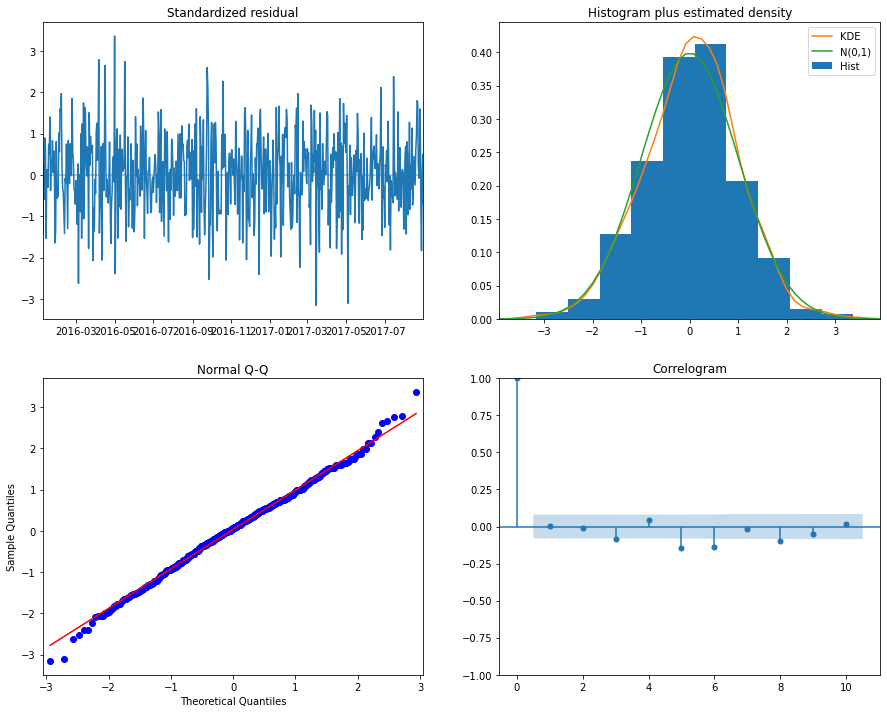

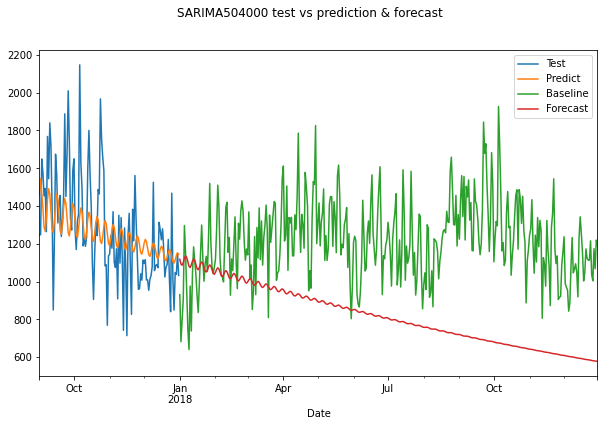

In [19]:
SARIMA101(5,0,4,0,0,0) # lowest MSE, we'll skip 2nd and 3rd since their ForeMSE isn't any better

In [20]:
display(sarima_score_df.sort_values('MAE').head(3)) #ignore all, we did 504000, which has much better overall scores

model  p  d  q  P  D  Q          MSE         MAE          AIC  \
272   SARIMA  1  0  1  0  0  2  61137.53290  178.749824  8023.303576   
1332  SARIMA  5  0  4  0  0  0  56829.62647  179.603289  8023.303576   
1514  SARIMA  6  0  0  0  0  2  64593.05073  182.823535  8023.303576   

          ForeMSE     ForeMAE  
272   355415.8225  536.192121  
1332  231241.5526  419.334757  
1514  445342.4416  609.081667

In [21]:
sarima_score_df.sort_values('AIC').head(3) #the MSE and ForeMSE are way too high, ignore all

model  p  d  q  P  D  Q           MSE          MAE          AIC  \
0     SARIMA  0  0  0  0  0  0  1.712959e+06  1278.711419  8023.303576   
1182  SARIMA  4  1  2  2  0  0  7.486197e+04   210.686355  8023.303576   
1181  SARIMA  4  1  2  1  1  2  8.975650e+04   244.468633  8023.303576   

           ForeMSE      ForeMAE  
0     1.521735e+06  1216.378437  
1182  4.216095e+04   161.442008  
1181  9.535963e+04   265.096996

In [22]:
display(sarima_score_df.sort_values('ForeMSE').head(3))
sarima_score_df.sort_values('ForeMAE').head(3)
# we will try the best ForeMSE and best ForeMAE score's parameters

model  p  d  q  P  D  Q          MSE         MAE          AIC  \
556  SARIMA  2  0  2  2  1  1  81987.34227  222.601272  8023.303576   
592  SARIMA  2  0  4  2  1  1  83171.92960  224.172635  8023.303576   
622  SARIMA  2  0  6  1  1  1  80224.64648  220.620797  8023.303576   

         ForeMSE     ForeMAE  
556  30691.31488  137.340165  
592  30715.00018  137.282622  
622  30741.45159  136.999826

model  p  d  q  P  D  Q          MSE         MAE          AIC  \
622  SARIMA  2  0  6  1  1  1  80224.64648  220.620797  8023.303576   
809  SARIMA  3  0  2  2  1  2  81510.94836  222.852715  8023.303576   
803  SARIMA  3  0  2  1  1  2  81101.90909  222.084643  8023.303576   

         ForeMSE     ForeMAE  
622  30741.45159  136.999826  
809  30830.43351  137.218813  
803  30799.15273  137.256071

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


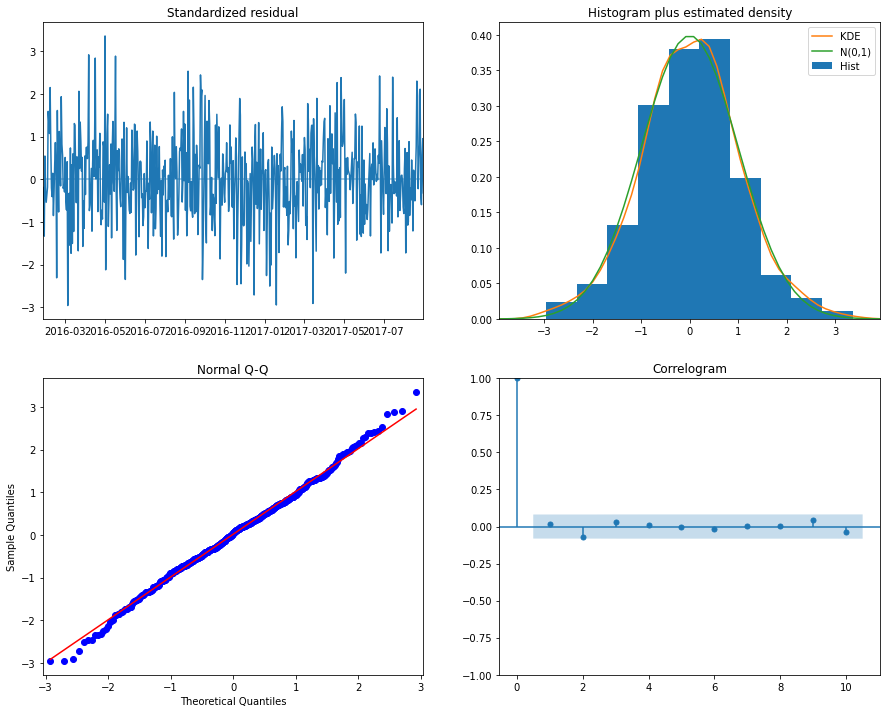

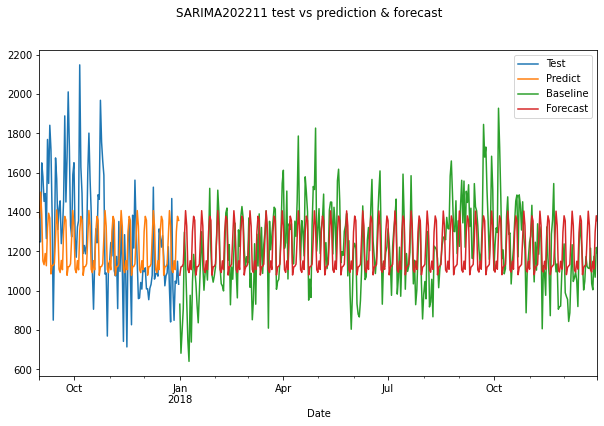

In [23]:
SARIMA101(2,0,2,2,1,1) #best ForeMSE score

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


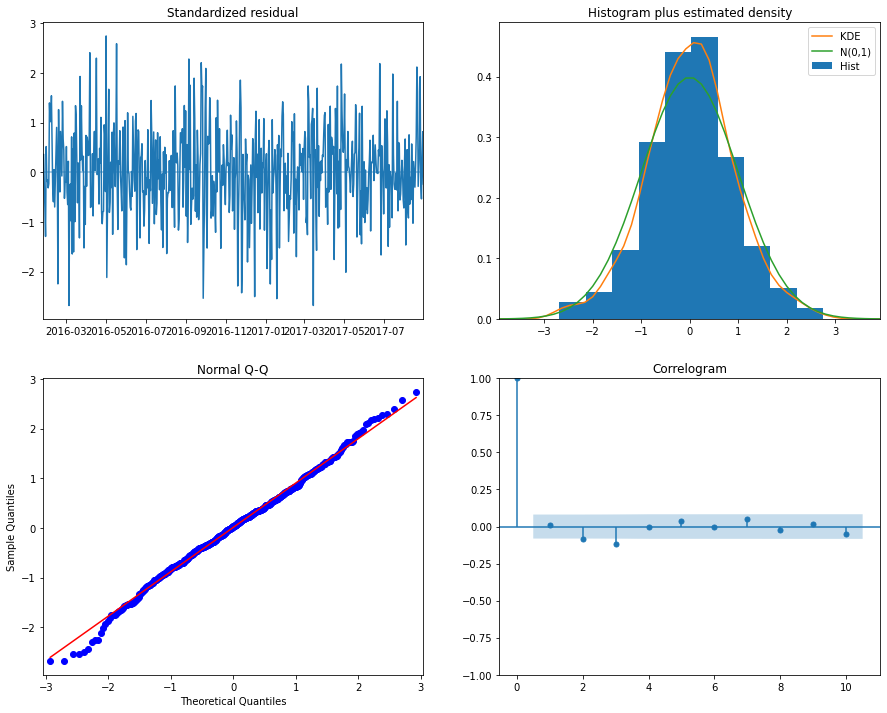

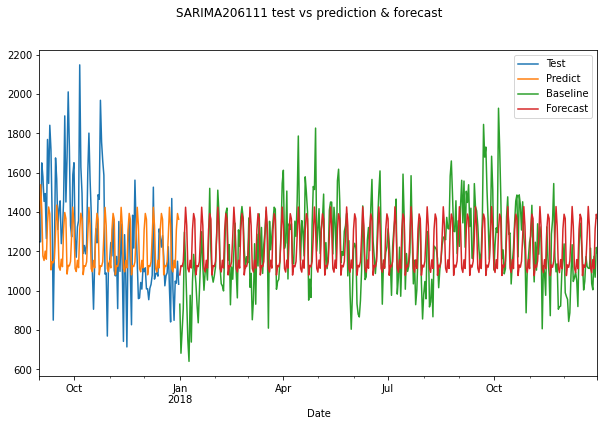

In [24]:
SARIMA101(2,0,6,1,1,1) #best ForeMAE score

Unfortunately, SARIMA also fails to capture the yearly seasonality.

# Holtwinters ExponentialSmoothing
This method is suitable for univariate time series with trend and/or seasonal components.

In [ ]:
# HES gridsearch and metric score recording
#create empty lists to store values
model_list = []
trend_list = []
seasonal_list = []
MSE_list = []
MAE_list = []
AIC_list = []
ForeMSE_list = []
ForeMAE_list = []
#iternation
for trnd in [None, 'add', 'mul']:
    for season in [None, 'add', 'mul']:
        # fit the model, trend is constant number which should be daily average sales
        model = ExponentialSmoothing(train, freq='D', seasonal_periods=7 ,trend=trnd, seasonal=season).fit()
        # get the prediction
        pred = model.predict(train_end,test_end)[1:]
        fore = model.predict(test_end, forecast_end)[1:]
        # append the values (calculate)
        model_list.append('HES')
        trend_list.append(trnd)
        seasonal_list.append(season)
        MSE_list.append(mean_squared_error(test,pred))
        MAE_list.append(mean_absolute_error(test,pred))
        AIC_list.append(model.aic)
        ForeMSE_list.append(mean_squared_error(baseline, fore))
        ForeMAE_list.append(mean_absolute_error(baseline, fore))

#create a dict to store the key:values then change to dataframe for easier/cleaner access
model_score_dict = {
    'model':model_list
    'trend': trend_list,
    'seasonal': seasonal_list,
    'MSE': MSE_list,
    'MAE': MAE_list,
    'AIC': AIC_list,
    'ForeMSE': ForeMSE_list,
    'ForeMAE': ForeMAE_list,
}

model_score_df = pd.DataFrame.from_dict(model_score_dict)
#save the dataframe to csv so we can load it next time instead of grid search everytime we restart
model_score_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\HES_gridsearch.csv',
                      index=False)

In [25]:
HES_score_df = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\HES_gridsearch.csv')
display(HES_score_df.sort_values('MSE').head(3))
display(HES_score_df.sort_values('MAE').head(3))
display(HES_score_df.sort_values('AIC').head(3))
display(HES_score_df.sort_values('ForeMSE').head(3))
display(HES_score_df.sort_values('ForeMAE').head(3))

model trend seasonal          MSE         MAE          AIC      ForeMSE  \
8   HES   mul      mul  86502.78930  241.075128  6406.942792  36919.07925   
6   HES   mul      NaN  89300.28125  251.926869  6611.385094  69220.06911   
0   HES   NaN      NaN  89995.68355  253.103487  6606.397791  71919.12757   

      ForeMAE  
8  147.751599  
6  216.991997  
0  222.103804

model trend seasonal          MSE         MAE          AIC      ForeMSE  \
8   HES   mul      mul  86502.78930  241.075128  6406.942792  36919.07925   
7   HES   mul      add  92055.30826  249.775821  6464.360256  40250.20055   
6   HES   mul      NaN  89300.28125  251.926869  6611.385094  69220.06911   

      ForeMAE  
8  147.751599  
7  158.159609  
6  216.991997

model trend seasonal          MSE         MAE          AIC       ForeMSE  \
1   HES   NaN      add  100748.4621  264.351634  6396.864806   73266.19453   
4   HES   add      add  126638.1387  299.428095  6400.912708  232989.56700   
2   HES   NaN      mul  105724.3640  270.111040  6403.000551   76676.32926   

      ForeMAE  
1  229.550888  
4  446.579345  
2  234.837518

model trend seasonal          MSE         MAE          AIC      ForeMSE  \
8   HES   mul      mul  86502.78930  241.075128  6406.942792  36919.07925   
7   HES   mul      add  92055.30826  249.775821  6464.360256  40250.20055   
6   HES   mul      NaN  89300.28125  251.926869  6611.385094  69220.06911   

      ForeMAE  
8  147.751599  
7  158.159609  
6  216.991997

model trend seasonal          MSE         MAE          AIC      ForeMSE  \
8   HES   mul      mul  86502.78930  241.075128  6406.942792  36919.07925   
7   HES   mul      add  92055.30826  249.775821  6464.360256  40250.20055   
6   HES   mul      NaN  89300.28125  251.926869  6611.385094  69220.06911   

      ForeMAE  
8  147.751599  
7  158.159609  
6  216.991997

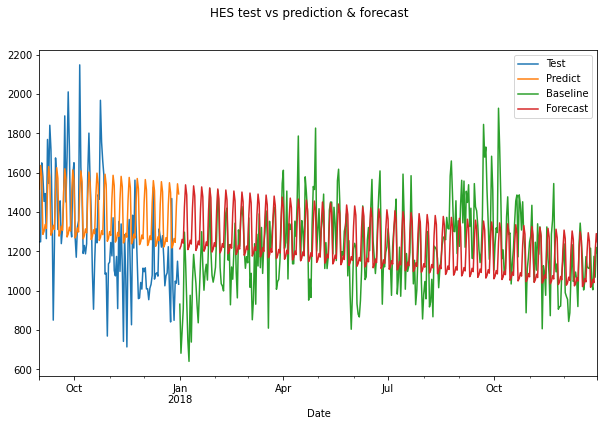

In [26]:
# trend mul anad seasonal mul seems to be the winner, let's fit and...etc
HES = ExponentialSmoothing(train, freq='D', seasonal_periods=7 ,trend='mul', seasonal='mul').fit()
# get the prediction
pred = HES.predict(train_end,test_end)[1:]
fore = HES.predict(test_end, forecast_end)[1:]
#view the plot of test vs pred
pd.DataFrame({'test':test,'pred':pred, 'baseline':baseline, 'forecast': fore}).plot(figsize=(10, 6))
plt.suptitle('HES test vs prediction & forecast')
plt.legend(["Test", "Predict", "Baseline", "Forecast"])
plt.savefig('HES_test_pred.png')
plt.show()

Worse than ARIMA/SARIMA

# TBATS
Trigonometric regressors to model multiple-seasonalities
Box-Cox transformations
ARMA errors
Trend
Seasonality

In [27]:
# Fit the model, seasonal_periods=(7, 364) for two seasonalities, 7 for weekly,
# and 364 for yearly since we have 364 rows per year of data
tbats = TBATS(seasonal_periods=(7, 364)).fit(train)

In [28]:
# Forecast days ahead
pred = tbats.forecast(steps=(len(test))) #we only need the next steps enough for testing data
fore = tbats.forecast(steps=(len(test)+364)) #need additional year (364) and also need to fill in the test data first

TBATS model MSE: 79309.45155101312
TBATS model MAE: 234.27815922676487
TBATS model AIC: 10264.989853974386
TBATS model ForeMSE: 36964.783072012375
TBATS model ForeMAE: 155.65340785623306


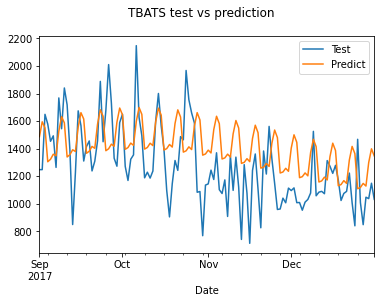

In [29]:
print('TBATS model MSE:', mean_squared_error(test,pred))
print('TBATS model MAE:', mean_absolute_error(test,pred))
print('TBATS model AIC:', tbats.aic)
print('TBATS model ForeMSE:', mean_squared_error(baseline,fore[122:])) #122 wass the test length, skip those, only need 2018
print('TBATS model ForeMAE:', mean_absolute_error(baseline,fore[122:]))
#view the plot of test vs pred
pd.DataFrame({'test':test,'pred':pred}).plot()
plt.suptitle('TBATS test vs prediction')
plt.legend(["Test", "Predict"])
plt.savefig('TBATS_test_pred.png')
plt.show()

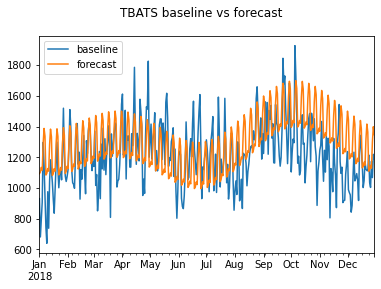

In [30]:
#view the 2018 forecast
pd.DataFrame({'baseline':baseline, 'forecast':fore[122:]}).plot()
plt.suptitle('TBATS baseline vs forecast')
plt.legend(["baseline", "forecast"])
plt.savefig('TBATS_baseline_forecast.png')
plt.show()

In [31]:
#create a dataframe and save the scores
TBATS_df = pd.DataFrame({
    'model':'TBATS',
    'MSE':mean_squared_error(test,pred),
    'MAE':mean_absolute_error(test,pred),
    'AIC':tbats.aic,
    'ForeMSE':mean_squared_error(baseline,fore[122:]),
    'ForeMAE':mean_absolute_error(baseline,fore[122:])}, index=[0])
TBATS_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\TBATS.csv',
                index=False)

In [32]:
TBATS_df = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\TBATS.csv')
TBATS_df

model           MSE         MAE           AIC       ForeMSE     ForeMAE
0  TBATS  79309.451551  234.278159  10264.989854  36964.783072  155.653408

The metric scores isn't as good as other models, but this model captures the weekly periodicity AND yearly seaonality!

# ARIMAX
ARIMA with features

In [33]:
# creating a new dataframe with additional date so we can do forecast
# since it's univariate, we will take the df2 daily sales, then just append 1s for the rest of the sales
Date = pd.date_range('2016-01-04', periods=1092, freq='D')
daily_list = list(df2.Daily)
for i in range(len(Date)-len(daily_list)):
    daily_list.append(1)
buf = {'Daily':daily_list}
buf = pd.DataFrame.from_dict(buf)
buf = buf.set_index(Date)

#month one hot encoding
buf['month'] = buf.index.month
month_dummies = pd.get_dummies(buf['month'])
month_dummies.columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
buf = pd.concat([buf, month_dummies], axis=1).drop(['month'],axis=1)
#dayofweek one hot encoding
buf['dayofweek'] = buf.index.weekday
week_dummies = pd.get_dummies(buf['dayofweek'])
week_dummies.columns = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
buf = pd.concat([buf, week_dummies], axis=1).drop(['dayofweek'],axis=1)
#defining exog_train and test and forecast
exog_train = buf[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',
                  'Mon','Tue','Wed','Thu','Fri','Sat','Sun']]['2016-01-04':'2017-08-31'].dropna()
exog_test = buf[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',
                 'Mon','Tue','Wed','Thu','Fri','Sat','Sun']]['2017-09-01':'2018-12-30'].dropna()

In [34]:
# check the forecast dates
model = sm.tsa.statespace.SARIMAX(train, order=(0,0,0), seasonal_order=(0,0,0,0), freq='D', exog=exog_train,
                                  enforce_stationarity=False, enforce_invertibility=False,).fit()
forecast = model.predict(train_end,forecast_end,exog = exog_test)[1:]
forecast[:122] #use this to calcualate metrics for test, needs 9/1~12/31 of 2017

2017-09-01    1380.565402
2017-09-02    1482.264025
2017-09-03    1434.636763
2017-09-04    1181.035148
2017-09-05    1194.345796
                 ...     
2017-12-27     998.171635
2017-12-28     984.584870
2017-12-29    1151.655512
2017-12-30    1253.354135
2017-12-31    1205.726873
Freq: D, Length: 122, dtype: float64

In [35]:
forecast[122:] # use this to calculate metrics for 2018 1/1-12/30 (364 days)

2018-01-01     920.630298
2018-01-02     933.940946
2018-01-03     966.676675
2018-01-04     953.089910
2018-01-05    1120.160553
                 ...     
2018-12-26     998.171635
2018-12-27     984.584870
2018-12-28    1151.655512
2018-12-29    1253.354135
2018-12-30    1205.726873
Freq: D, Length: 364, dtype: float64

In [ ]:
# Grid search for best params and record metric scores
#create empty lists to store values
model_list = []
p_list = []
d_list = []
q_list = []
MSE_list = []
MAE_list = []
AIC_list = []
ForeMSE_list = []
ForeMAE_list = []
#iternation
for p in range(8):
    for d in [0, 1]:
        for q in range(8):
            # fit the model, trend is constant number which should be daily average sales
            model = sm.tsa.statespace.SARIMAX(train, order=(p,d,q), seasonal_order=(0,0,0,0), freq='D', exog=exog_train,
                                               enforce_stationarity=False, enforce_invertibility=False,).fit()
            # get the prediction
            forecast = model.predict(train_end,forecast_end,exog = exog_test)[1:]
            pred = forecast[:122]
            fore = forecast[122:]
            # append the values (caculate)
            model_list.append('ARIMAX')
            p_list.append(p)
            d_list.append(d)
            q_list.append(q)
            MSE_list.append(mean_squared_error(test,pred))
            MAE_list.append(mean_absolute_error(test,pred))
            AIC_list.append(model.aic)
            ForeMSE_list.append(mean_squared_error(baseline,fore))
            ForeMAE_list.append(mean_absolute_error(baseline,fore))
            #create a dataframe to store the scores
arimax_score_df = pd.DataFrame({
    'model':model_list,
    'p': p_list,
    'd': d_list,
    'q': q_list,
    'MSE': MSE_list,
    'MAE': MAE_list,
    'AIC': AIC_list,
    'ForeMSE':ForeMSE_list,
    'ForeMAE':ForeMAE_list})
arimax_score_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\arimax_gridsearch.csv',
                      index=False)

In [36]:
arimax_score_df = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\arimax_gridsearch.csv')
display(arimax_score_df.sort_values('MSE').head(3))
display(arimax_score_df.sort_values('MAE').head(3))
display(arimax_score_df.sort_values('AIC').head(3))
display(arimax_score_df.sort_values('ForeMSE').head(3))
display(arimax_score_df.sort_values('ForeMAE').head(3))

model  p  d  q           MSE         MAE          AIC       ForeMSE  \
83  ARIMAX  5  0  3  65873.074606  193.495806  8029.195843  22576.327364   
99  ARIMAX  6  0  3  65981.493356  193.961844  8020.130097  22725.925348   
82  ARIMAX  5  0  2  65981.923235  192.744925  8030.793798  22531.454958   

       ForeMAE  
83  116.106628  
99  116.402870  
82  116.919819

model  p  d  q           MSE         MAE          AIC       ForeMSE  \
0   ARIMAX  0  0  0  66016.766390  192.521422  8166.199880  22544.877840   
1   ARIMAX  0  0  1  66075.969724  192.693170  8076.978941  22550.514650   
82  ARIMAX  5  0  2  65981.923235  192.744925  8030.793798  22531.454958   

       ForeMAE  
0   116.979432  
1   116.997730  
82  116.919819

model  p  d  q           MSE         MAE          AIC       ForeMSE  \
7   ARIMAX  0  0  7  66296.743219  193.201030  7985.138949  22554.640898   
39  ARIMAX  2  0  7  70557.437849  200.809365  7986.163174  22570.373124   
23  ARIMAX  1  0  7  66251.964118  193.114894  7987.042372  22549.782058   

       ForeMAE  
7   117.006339  
39  117.002112  
23  117.002203

model  p  d  q           MSE         MAE          AIC       ForeMSE  \
82  ARIMAX  5  0  2  65981.923235  192.744925  8030.793798  22531.454958   
51  ARIMAX  3  0  3  67385.958588  195.072834  8033.080664  22534.574832   
86  ARIMAX  5  0  6  67383.241912  195.066074  8002.977375  22539.110393   

       ForeMAE  
82  116.919819  
51  116.981630  
86  116.978753

model  p  d  q           MSE         MAE          AIC       ForeMSE  \
83  ARIMAX  5  0  3  65873.074606  193.495806  8029.195843  22576.327364   
84  ARIMAX  5  0  4  70054.189393  200.955517  8026.350145  22640.711729   
99  ARIMAX  6  0  3  65981.493356  193.961844  8020.130097  22725.925348   

       ForeMAE  
83  116.106628  
84  116.219088  
99  116.402870

In [37]:
# create a function to take in model name and the parameters for SARIMAX, fit, plot diagnostics,
# plot the test vs predict and save the figure
def SARIMAX101(p, d, q, P, D, Q, m):
    #fit the model with given params
    model = sm.tsa.statespace.SARIMAX(train, order=(p,d,q), freq='D', seasonal_order=(P,D,Q,m), exog=exog_train, 
                                      enforce_stationarity=False, enforce_invertibility=False,).fit()
    #get the diagnostics for the model
    model.plot_diagnostics(figsize=(15, 12))
    plt.show()
    #forecasts
    forecast = model.predict(train_end,forecast_end,exog = exog_test)[1:]
    pred = forecast[:122]
    fore = forecast[122:]
    #view the plot of test vs pred
    pd.DataFrame({'test':test,'pred':pred, 'baseline':baseline, 'forecast': fore}).plot(figsize=(10, 6))
    plt.suptitle('SARIMAX{} test vs prediction & forecast'.format(str(p)+str(d)+str(q)+str(P)+str(D)+str(Q)+str(m)))
    plt.legend(["Test", "Predict", "Baseline", "Forecast"])
    plt.savefig('sarimax{}_test_pred.png'.format(str(p)+str(d)+str(q)+str(P)+str(D)+str(Q)+str(m)))
    plt.show()
    return

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


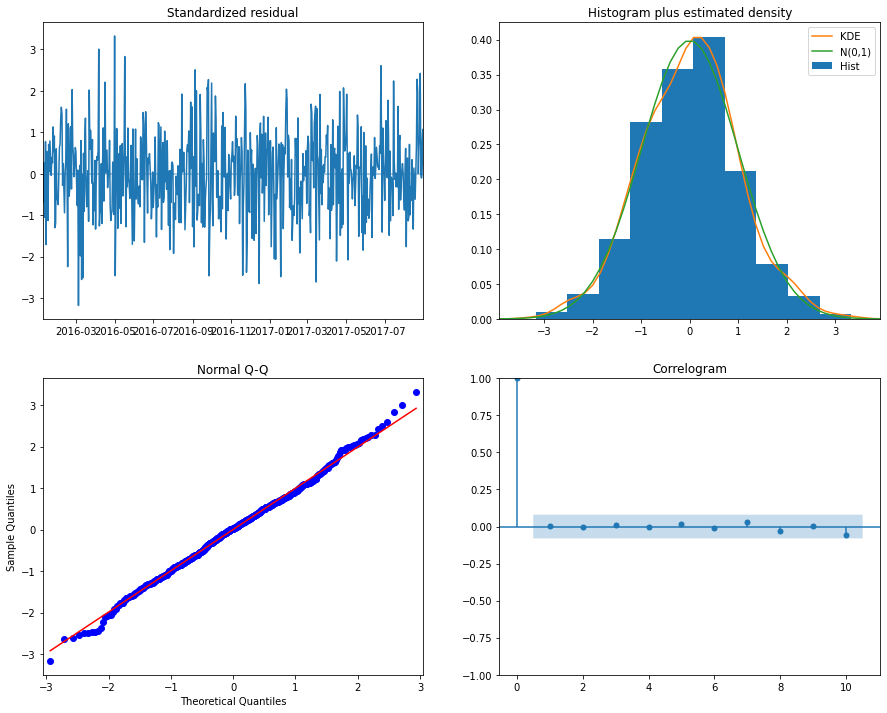

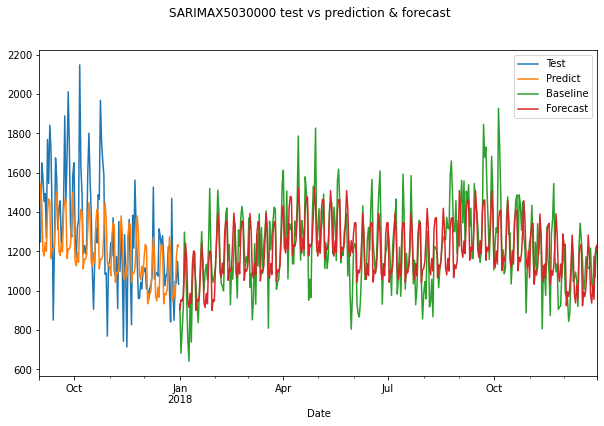

In [38]:
# we'll try the top score of each category
SARIMAX101(5,0,3,0,0,0,0) #top MSE and ForeMAE

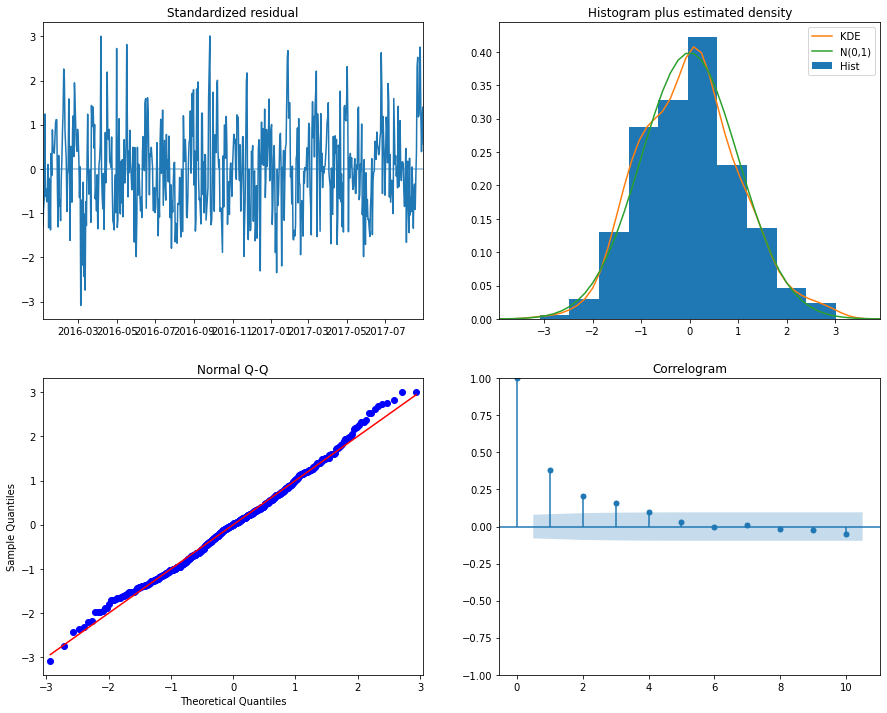

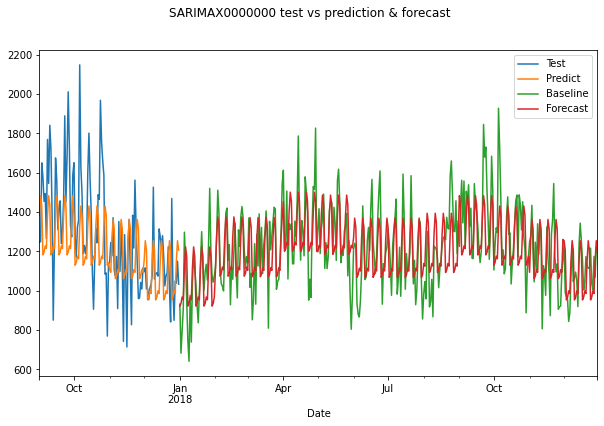

In [39]:
SARIMAX101(0,0,0,0,0,0,0) #top MAE

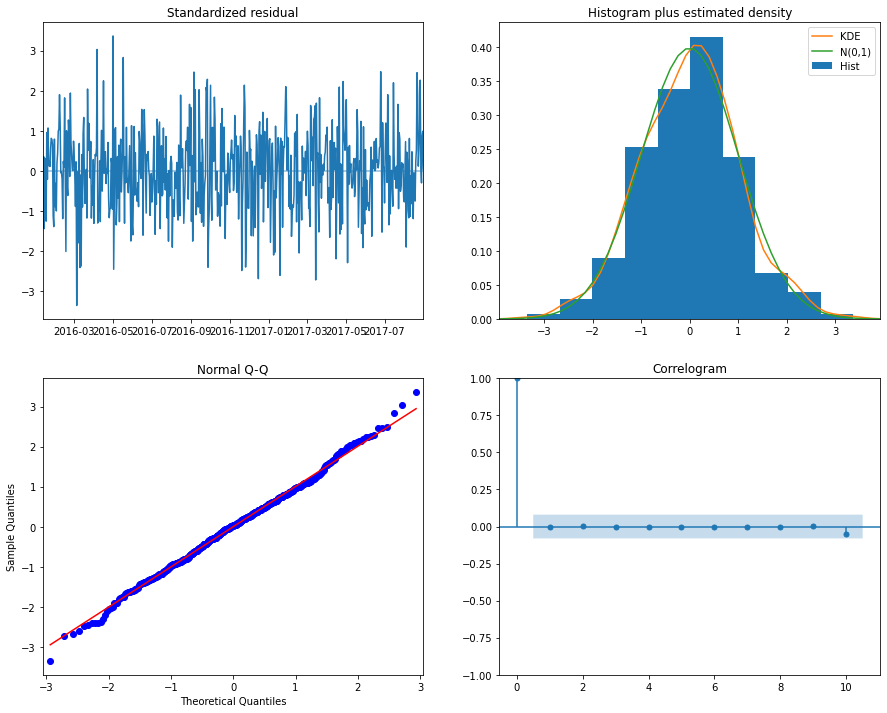

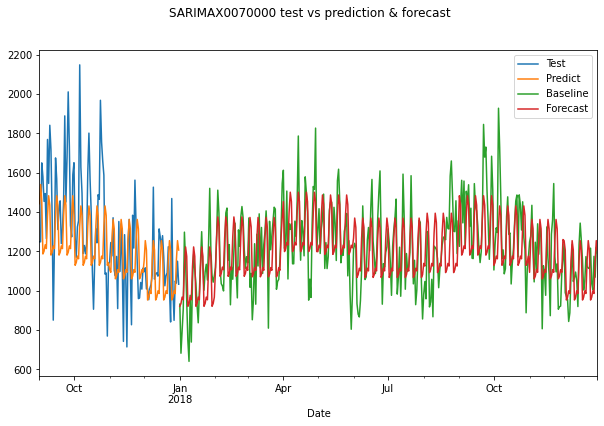

In [40]:
SARIMAX101(0,0,7,0,0,0,0) #top AIC

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


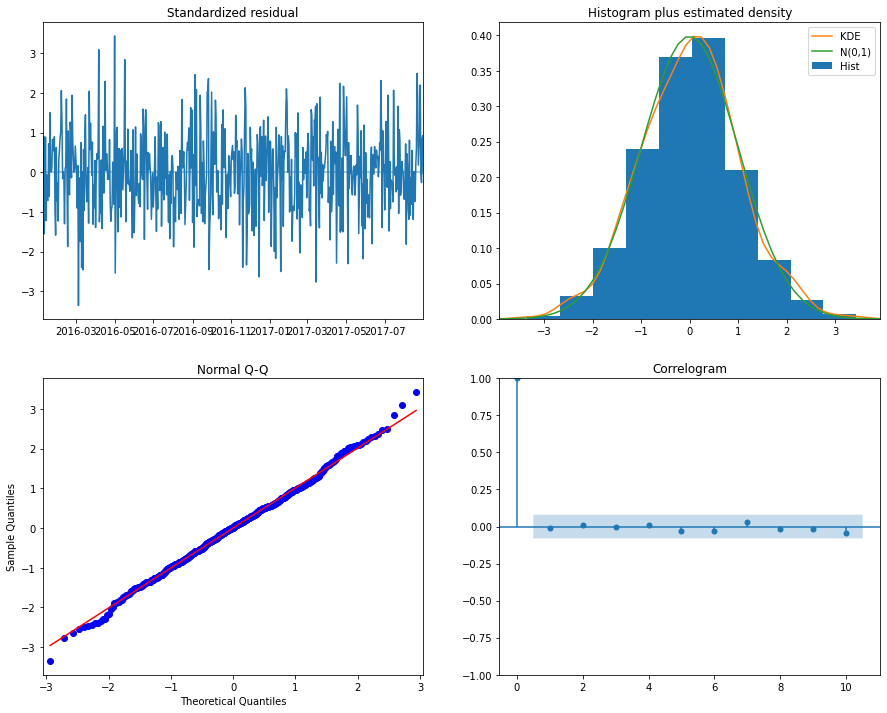

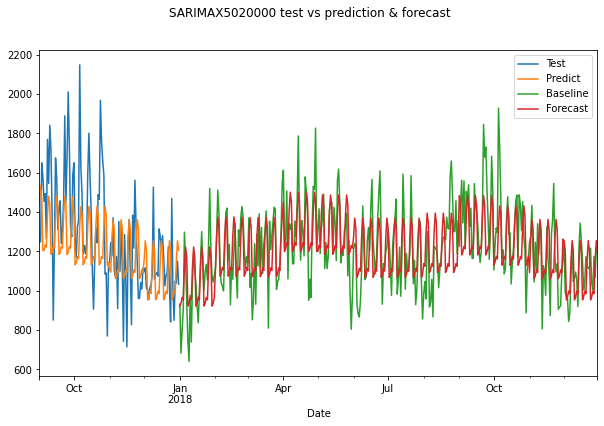

In [41]:
SARIMAX101(5,0,2,0,0,0,0) #top ForeMSE

The features helped a lot! All of the ARIMAX models captured the weekly and yearly seasonality!

# SARIMAX

In [ ]:
# Grid search for best params and record scores
#Since we are setting seasonality in weekly basis, m=7, it will influence order params so we need to adjust them as well
#we know d = 0 b/c dataset is stationary, we will leave it as it is.
#for SARIMAX the higher the order the slower it takes, we will evenly distribute to maximum order of 12; maximum p/P/q/Q=3
#D is usually 0 or 1
#create empty lists to store values
model_list = []
p_list = []
d_list = []
q_list = []
P_list = []
D_list = []
Q_list = []
MSE_list = []
MAE_list = []
AIC_list = []
ForeMSE_list = []
ForeMAE_list = []
#gridsearch iternation, since arima504 and arimax503 were top MSE scores in its model, i want to include p =5 and q=3,4
for p in [0,1,2,5]:
    for d in range(2):
        for q in range(5):
            for P in range(2):
                for D in [0,1]:
                    for Q in range(2):
                        # fit the model
                        model = sm.tsa.statespace.SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q,7), freq='D',
                                                            exog=exog_train,
                                                           enforce_stationarity=False, 
                                                           enforce_invertibility=False,).fit()
                        # forecasts
                        forecast = model.predict(train_end,forecast_end,exog = exog_test)[1:]
                        pred = forecast[:122]
                        fore = forecast[122:]
                        # append the values (calculate)
                        model_list.append('SARIMAX')
                        p_list.append(p)
                        d_list.append(d)
                        q_list.append(q)
                        P_list.append(P)
                        D_list.append(D)
                        Q_list.append(Q)
                        MSE_list.append(mean_squared_error(test,pred))
                        MAE_list.append(mean_absolute_error(test,pred))
                        AIC_list.append(model.aic)
                        ForeMSE_list.append(mean_squared_error(baseline,fore))
                        ForeMAE_list.append(mean_absolute_error(baseline,fore))                   

In [45]:
#create a dataframe to store as csv
sarimax_score_df = pd.DataFrame({
    'model':model_list,
    'p': p_list,
    'd': d_list,
    'q': q_list,
    'P': P_list,
    'D': D_list,
    'Q': Q_list,
    'MSE': MSE_list,
    'MAE': MAE_list,
    'AIC': AIC_list,
    'ForeMSE':ForeMSE_list,
    'ForeMAE':ForeMAE_list})
#save the dataframe to csv so we can load it next time instead of grid search everytime we restart
sarimax_score_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\sarimax_gridsearch.csv',
                       index=False)

In [46]:
sarimax_score_df = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\sarimax_gridsearch.csv')
display(sarimax_score_df.sort_values('MSE').head(3))
display(sarimax_score_df.sort_values('MAE').head(3))
display(sarimax_score_df.sort_values('AIC').head(3))
display(sarimax_score_df.sort_values('ForeMSE').head(3))
display(sarimax_score_df.sort_values('ForeMAE').head(3))

model  p  d  q  P  D  Q           MSE         MAE          AIC  \
260  SARIMAX  5  0  2  1  0  0  65760.909437  193.471264  7939.056262   
264  SARIMAX  5  0  3  0  0  0  65873.074606  193.495806  8029.195843   
269  SARIMAX  5  0  3  1  0  1  65879.350123  193.648229  7940.515694   

          ForeMSE     ForeMAE  
260  22704.976409  116.359742  
264  22576.327364  116.106628  
269  22670.908651  116.273756

model  p  d  q  P  D  Q           MSE         MAE          AIC  \
5   SARIMAX  0  0  0  1  0  1  65903.360646  191.998003  8076.731427   
4   SARIMAX  0  0  0  1  0  0  65986.388282  192.240132  8088.224671   
17  SARIMAX  0  0  2  0  0  1  66056.501214  192.457675  7965.062534   

         ForeMSE     ForeMAE  
5   22572.938282  116.913271  
4   22565.935834  116.963609  
17  22624.064638  117.031592

model  p  d  q  P  D  Q           MSE         MAE          AIC  \
35   SARIMAX  0  0  4  0  1  1  75122.850407  205.571820  7872.071180   
39   SARIMAX  0  0  4  1  1  1  75991.919826  207.810908  7876.046133   
247  SARIMAX  5  0  0  1  1  1  78656.194975  211.653774  7876.067544   

         ForeMSE     ForeMAE  
35   24781.53207  122.329828  
39   25233.44067  123.115089  
247  26353.48794  126.525692

model  p  d  q  P  D  Q           MSE         MAE          AIC  \
256  SARIMAX  5  0  2  0  0  0  65981.923235  192.744925  8030.793798   
0    SARIMAX  0  0  0  0  0  0  66016.766390  192.521422  8166.199880   
257  SARIMAX  5  0  2  0  0  1  67885.421367  195.241593  8272.519228   

          ForeMSE     ForeMAE  
256  22531.454958  116.919819  
0    22544.877840  116.979432  
257  22549.554663  116.999665

model  p  d  q  P  D  Q           MSE         MAE          AIC  \
264  SARIMAX  5  0  3  0  0  0  65873.074606  193.495806  8029.195843   
277  SARIMAX  5  0  4  1  0  1  71162.398215  202.801320  7938.981930   
273  SARIMAX  5  0  4  0  0  1  71186.667588  202.861926  7937.020347   

          ForeMSE     ForeMAE  
264  22576.327364  116.106628  
277  22585.139288  116.109044  
273  22613.469113  116.157570

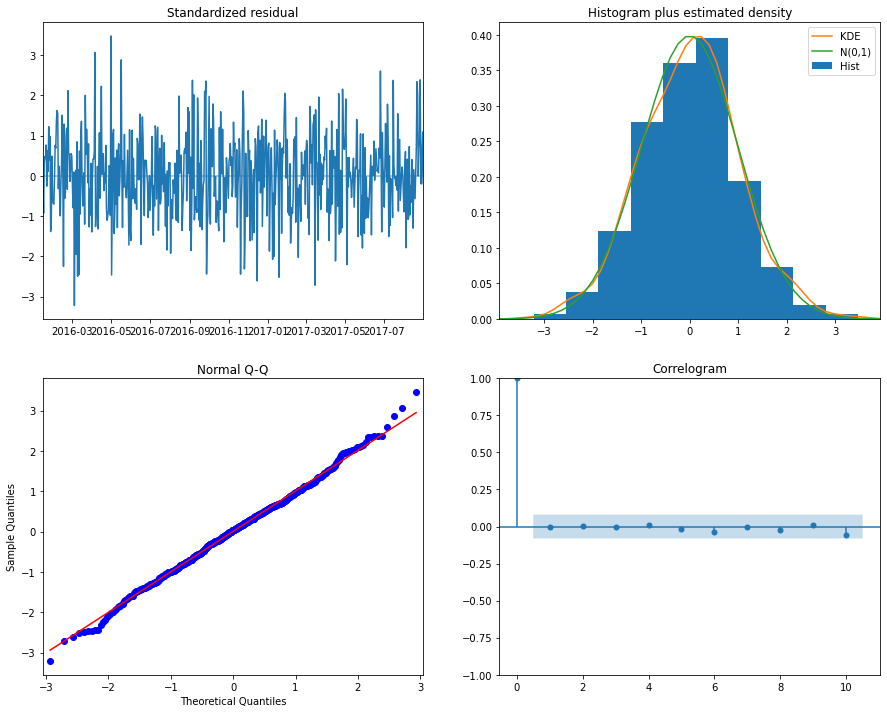

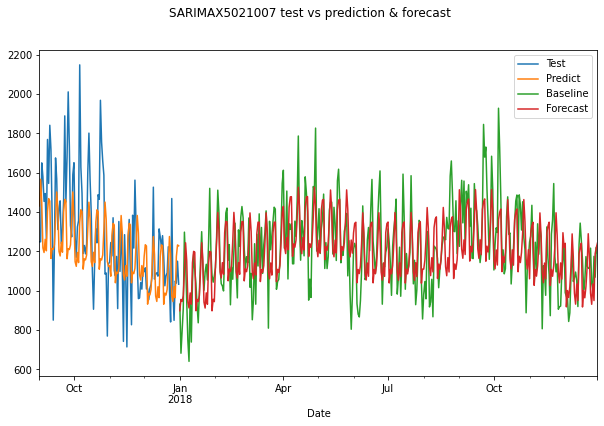

In [47]:
#most of the SARIMAX models had same similar MSE/MAE/ForeMSE/ForeMAE, we'll try top score of each category
SARIMAX101(5,0,2,1,0,0,7) #best MSE

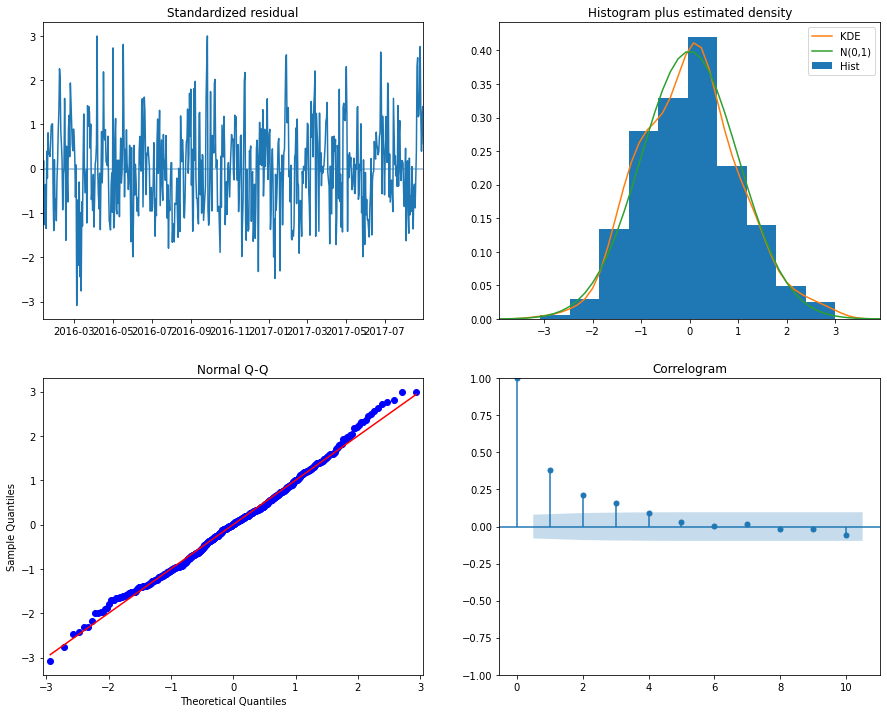

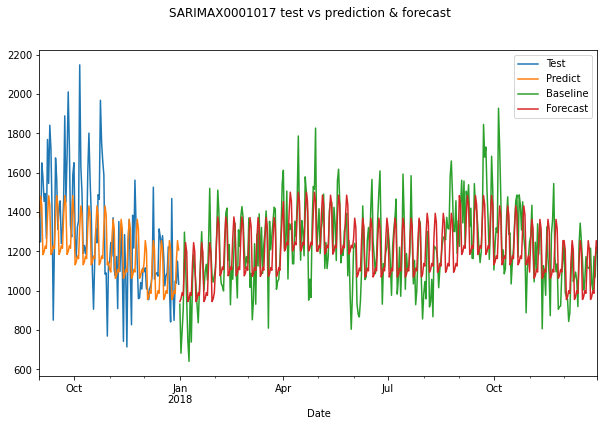

In [48]:
SARIMAX101(0,0,0,1,0,1,7) #best MAE

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


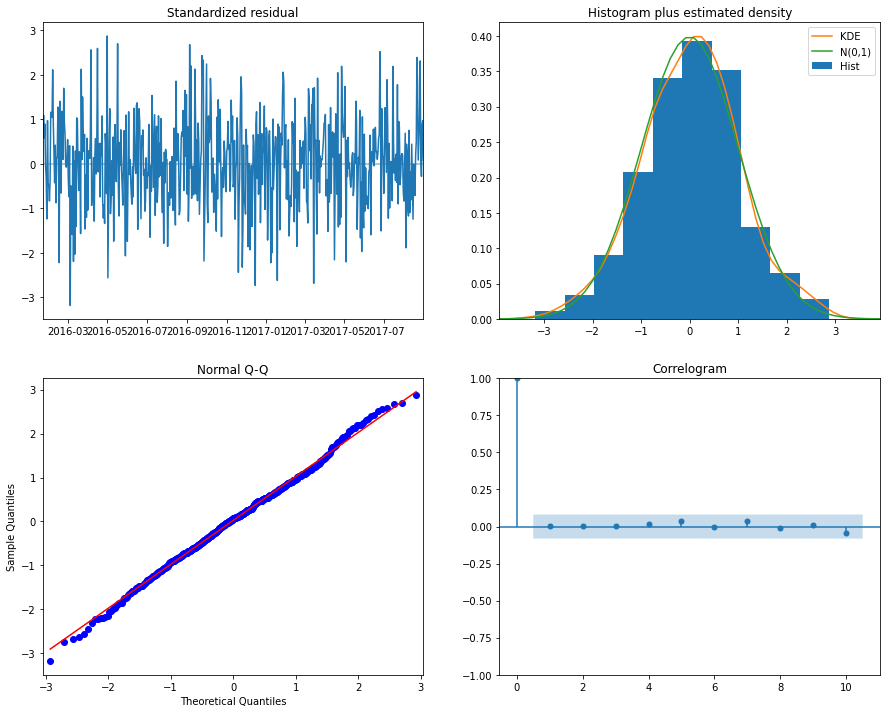

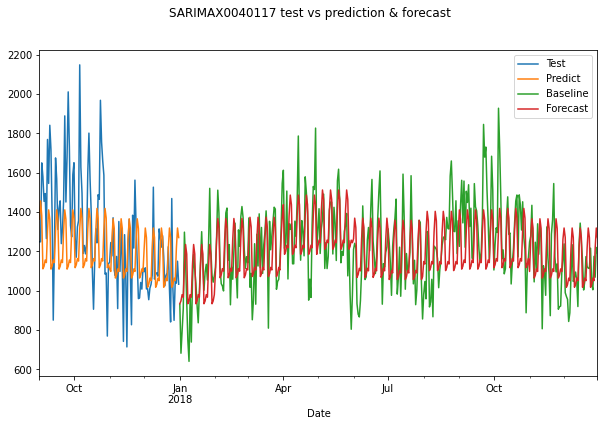

In [49]:
SARIMAX101(0,0,4,0,1,1,7) #best AIC

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


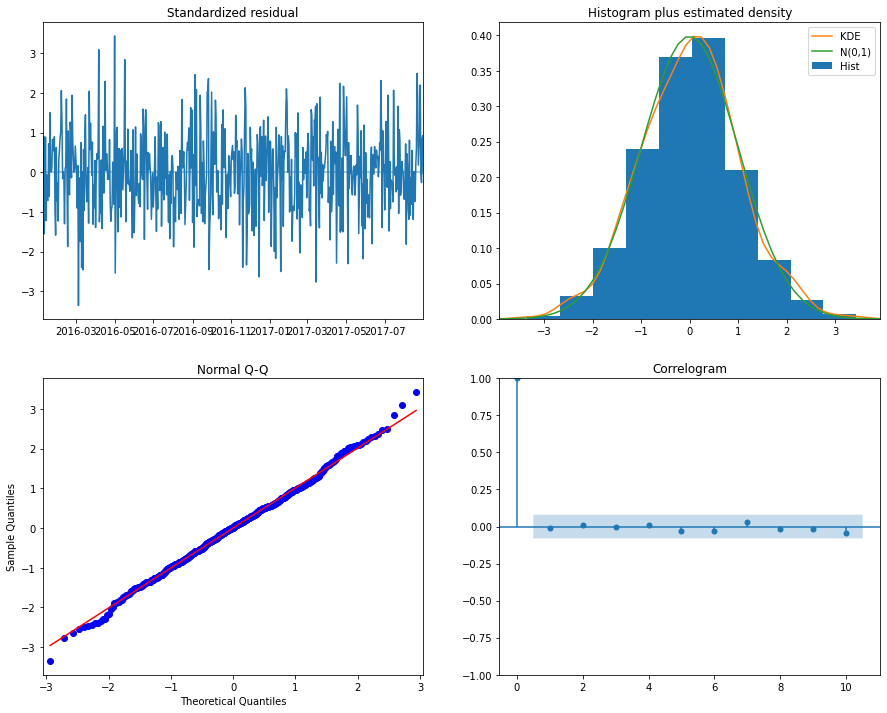

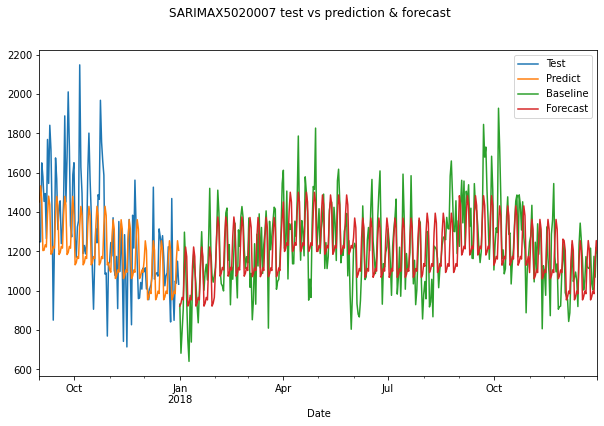

In [50]:
SARIMAX101(5,0,2,0,0,0,7) #best ForeMSE

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


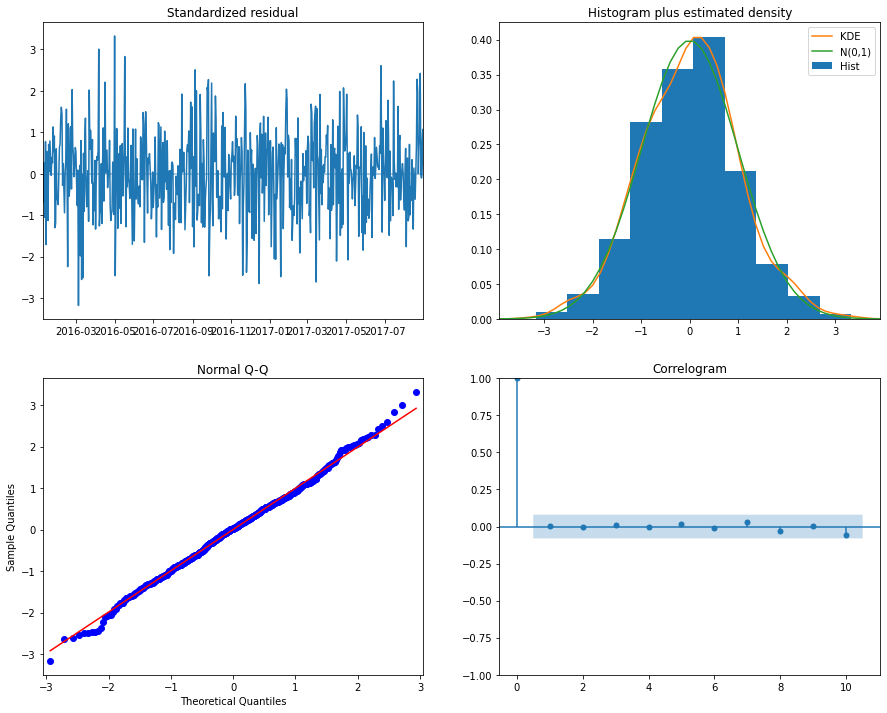

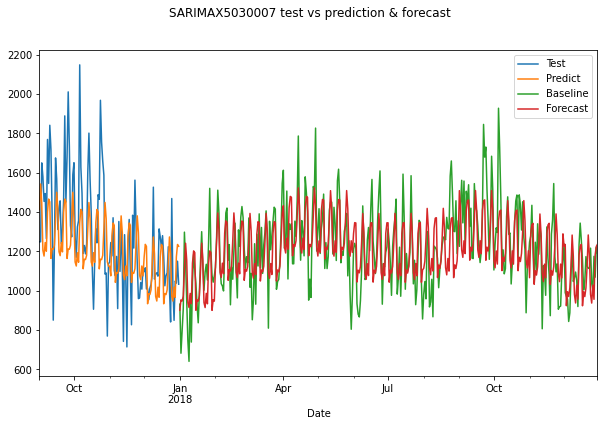

In [51]:
SARIMAX101(5,0,3,0,0,0,7) #best ForeMAE

Very similar results to ARIMAX

# Fourier Term features

In [52]:
# once again build a df with additiona dates
Date = pd.date_range('2016-01-04', periods=1092, freq='D')
daily_list = list(df2.Daily)
for i in range(len(Date)-len(daily_list)):
    daily_list.append(1)
buf = {'Daily':daily_list}
buf = pd.DataFrame.from_dict(buf)
buf = buf.set_index(Date)

In [53]:
# create empty lists to store values
FT_list = []
MSE_list = []
MAE_list = []
ForeMSE_list = []
ForeMAE_list = []

In [ ]:
# record MSE/MAE/ForeMSE/ForeMAE into a dataframe then into csv file
# prepare fourier term feature with 1 term
exog = buf.copy()
exog['sin364'] = np.sin(2 * np.pi * exog.index.dayofyear / 364)
exog['cos364'] = np.cos(2 * np.pi * exog.index.dayofyear / 364)
exog = exog.drop(columns=['Daily'])
exog_to_train = exog.iloc[:(len(df2)-122)]
exog_to_test = exog.iloc[len(exog_to_train):]
# auto_arima with m=7
AA_model = auto_arima(y=train, exogenous=exog_to_train, seasonal=True, m=7)
# Forecast
forecast = AA_model.predict(n_periods=486, exogenous=exog_to_test)
pred = forecast[:122]
fore = forecast[122:]
# append the results to the empty lists
FT_list.append('FT 1 term')
MSE_list.append(mean_squared_error(test,pred))
MAE_list.append(mean_absolute_error(test,pred))
ForeMSE_list.append(mean_squared_error(baseline,fore))
ForeMAE_list.append(mean_absolute_error(baseline,fore))

In [ ]:
# 2 terms
exog = buf.copy()
exog['sin364'] = np.sin(2 * np.pi * exog.index.dayofyear / 364)
exog['cos364'] = np.cos(2 * np.pi * exog.index.dayofyear / 364)
exog['sin364_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 364)
exog['cos364_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 364)
exog = exog.drop(columns=['Daily'])
exog_to_train = exog.iloc[:(len(df2)-122)]
exog_to_test = exog.iloc[len(exog_to_train):]
# auto_arima with m=7
AA_model = auto_arima(y=train, exogenous=exog_to_train, seasonal=True, m=7)
# Forecast
forecast = AA_model.predict(n_periods=486, exogenous=exog_to_test)
pred = forecast[:122]
fore = forecast[122:]
# append the results to the empty lists
FT_list.append('FT 2 terms')
MSE_list.append(mean_squared_error(test,pred))
MAE_list.append(mean_absolute_error(test,pred))
ForeMSE_list.append(mean_squared_error(baseline,fore))
ForeMAE_list.append(mean_absolute_error(baseline,fore))

In [ ]:
# 3 terms
exog = buf.copy()
exog['sin364'] = np.sin(2 * np.pi * exog.index.dayofyear / 364)
exog['cos364'] = np.cos(2 * np.pi * exog.index.dayofyear / 364)
exog['sin364_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 364)
exog['cos364_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 364)
exog['sin364_3'] = np.sin(6 * np.pi * exog.index.dayofyear / 364)
exog['cos364_3'] = np.cos(6 * np.pi * exog.index.dayofyear / 364)
exog = exog.drop(columns=['Daily'])
exog_to_train = exog.iloc[:(len(df2)-122)]
exog_to_test = exog.iloc[len(exog_to_train):]
# auto_arima with m=7
AA_model = auto_arima(y=train, exogenous=exog_to_train, seasonal=True, m=7)
# Forecast
forecast = AA_model.predict(n_periods=486, exogenous=exog_to_test)
pred = forecast[:122]
fore = forecast[122:]
# append the results to the empty lists
FT_list.append('FT 3 terms')
MSE_list.append(mean_squared_error(test,pred))
MAE_list.append(mean_absolute_error(test,pred))
ForeMSE_list.append(mean_squared_error(baseline,fore))
ForeMAE_list.append(mean_absolute_error(baseline,fore))

In [ ]:
# 4 terms
exog = buf.copy()
exog['sin364'] = np.sin(2 * np.pi * exog.index.dayofyear / 364)
exog['cos364'] = np.cos(2 * np.pi * exog.index.dayofyear / 364)
exog['sin364_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 364)
exog['cos364_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 364)
exog['sin364_3'] = np.sin(6 * np.pi * exog.index.dayofyear / 364)
exog['cos364_3'] = np.cos(6 * np.pi * exog.index.dayofyear / 364)
exog['sin364_4'] = np.sin(8 * np.pi * exog.index.dayofyear / 364)
exog['cos364_4'] = np.cos(8 * np.pi * exog.index.dayofyear / 364)
exog = exog.drop(columns=['Daily'])
exog_to_train = exog.iloc[:(len(df2)-122)]
exog_to_test = exog.iloc[len(exog_to_train):]
# auto_arima with m=7
AA_model = auto_arima(y=train, exogenous=exog_to_train, seasonal=True, m=7)
# Forecast
forecast = AA_model.predict(n_periods=486, exogenous=exog_to_test)
pred = forecast[:122]
fore = forecast[122:]
# append the results to the empty lists
FT_list.append('FT 4 terms')
MSE_list.append(mean_squared_error(test,pred))
MAE_list.append(mean_absolute_error(test,pred))
ForeMSE_list.append(mean_squared_error(baseline,fore))
ForeMAE_list.append(mean_absolute_error(baseline,fore))

In [ ]:
# make a dataframe with the score recorded save to csv file and view the top scores
FT_score_df = pd.DataFrame({
    'model': FT_list,
    'MSE': MSE_list,
    'MAE': MAE_list,
    'ForeMSE': ForeMSE_list,
    'ForeMAE': ForeMAE_list})
FT_score_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\FT_scores.csv',
                   index=False)

In [55]:
FT_score_df = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\FT_scores.csv')
display(FT_score_df.sort_values('MSE').head(3))
display(FT_score_df.sort_values('MAE').head(3))
display(FT_score_df.sort_values('ForeMSE').head(3))
display(FT_score_df.sort_values('ForeMAE').head(3))

model          MSE         MAE      ForeMSE     ForeMAE
2  FT 3 terms  66878.60416  186.084988  34646.62841  145.928226
3  FT 4 terms  67481.78341  187.524357  34434.46841  145.049816
1  FT 2 terms  75344.19381  197.463818  36121.58030  148.126184

model          MSE         MAE      ForeMSE     ForeMAE
2  FT 3 terms  66878.60416  186.084988  34646.62841  145.928226
3  FT 4 terms  67481.78341  187.524357  34434.46841  145.049816
1  FT 2 terms  75344.19381  197.463818  36121.58030  148.126184

model          MSE         MAE      ForeMSE     ForeMAE
3  FT 4 terms  67481.78341  187.524357  34434.46841  145.049816
2  FT 3 terms  66878.60416  186.084988  34646.62841  145.928226
1  FT 2 terms  75344.19381  197.463818  36121.58030  148.126184

model          MSE         MAE      ForeMSE     ForeMAE
3  FT 4 terms  67481.78341  187.524357  34434.46841  145.049816
2  FT 3 terms  66878.60416  186.084988  34646.62841  145.928226
1  FT 2 terms  75344.19381  197.463818  36121.58030  148.126184

4 Terms have better 2018 scores while 3 Terms have better pred vs test score. However, the ForeMSE score between 3 and 4 terms aren't too different, so we will keep 3 terms for faster calculation.

In [ ]:
# let's proceed to view the plots from fourier 3 terms using auto_arima
exog = buf.copy()
exog['sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 364)
exog['cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 364)
exog['sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 364)
exog['cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 364)
exog['sin365_3'] = np.sin(4 * np.pi * exog.index.dayofyear / 364)
exog['cos365_3'] = np.cos(4 * np.pi * exog.index.dayofyear / 364)
exog = exog.drop(columns=['Daily'])
exog_to_train = exog.iloc[:(len(df2)-122)]
exog_to_test = exog.iloc[len(exog_to_train):]
# auto_arima with m=7
AA_model = auto_arima(y=train, exogenous=exog_to_train, seasonal=True, m=7)
# Forecast
forecast = AA_model.predict(n_periods=486, exogenous=exog_to_test)
pred = forecast[:122]
fore = forecast[122:]
# plot test vs pred
pd.DataFrame({'test':test,'pred':pred}).plot(figsize=(10, 6))
plt.suptitle('AA-FT3 test vs prediction')
plt.legend(["Test", "Predict"])
plt.savefig('AA_FT3_test_pred.png')
plt.show()

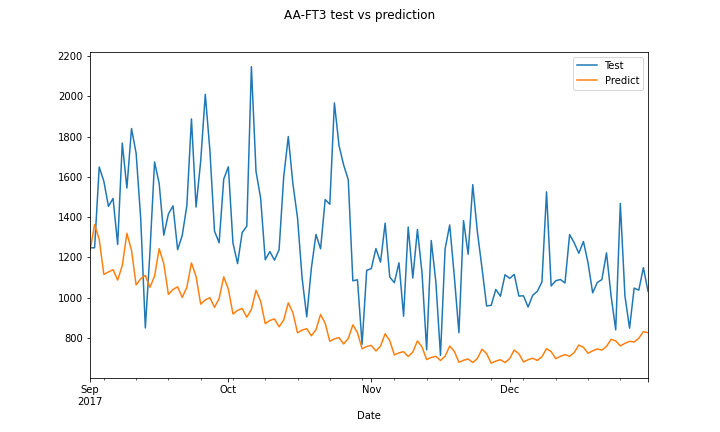

In [58]:
Image('AA_FT3_test_pred.png')

The weekly periodicity seems to wear off over time, which isn't true, and the estimate seems off by a lot.

In [ ]:
#view the plot of baseline vs forecast for 2018
pd.DataFrame({'baseline':baseline,'forecast':fore}).plot(figsize=(10, 6))
plt.suptitle('AA-FT3 2018 baseline vs forecast')
plt.legend(["baseline", "forecast"])
plt.savefig('AA_FT3_base_fore.png')

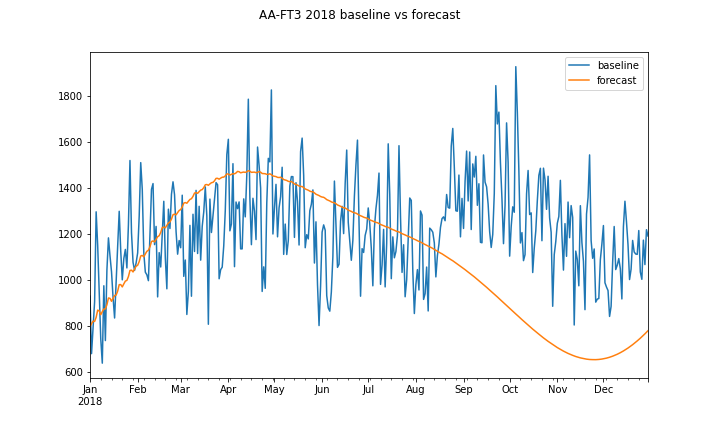

In [59]:
Image('AA_FT3_base_fore.png')

There's some yearly seasonal trend, but it's off.

# Fourier Terms with DoW and Month as exog features

In [60]:
# create empty lists to store values
FT_list = []
MSE_list = []
MAE_list = []
ForeMSE_list = []
ForeMAE_list = []
# prepare DoW and month exog
exog = buf.copy()
#month one hot encoding
exog['month'] = exog.index.month
month_dummies = pd.get_dummies(exog['month'])
month_dummies.columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
exog = pd.concat([exog, month_dummies], axis=1).drop(['month'],axis=1)
#dayofweek one hot encoding
exog['dayofweek'] = exog.index.weekday
week_dummies = pd.get_dummies(exog['dayofweek'])
week_dummies.columns = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
exog = pd.concat([exog, week_dummies], axis=1).drop(['dayofweek'],axis=1)
# prepare fourier terms
exog['sin364'] = np.sin(2 * np.pi * exog.index.dayofyear / 364)
exog['cos364'] = np.cos(2 * np.pi * exog.index.dayofyear / 364)
exog = exog.drop(columns=['Daily'])
exog_to_train = exog[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',
                      'Mon','Tue','Wed','Thu','Fri','Sat','Sun',
                      'sin364','cos364']]['2016-01-04':'2017-08-31'].dropna()
exog_to_test = exog[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',
                     'Mon','Tue','Wed','Thu','Fri','Sat','Sun',
                     'sin364','cos364']]['2017-09-01':'2018-12-30'].dropna()

In [ ]:
# auto_arima with m=7
AA_model = auto_arima(y=train, exogenous=exog_to_train, seasonal=True, m=7)
# Forecast
forecast = AA_model.predict(n_periods=486, exogenous=exog_to_test)
pred = forecast[:122]
fore = forecast[122:]
# append the results to the empty lists
FT_list.append('FTX 1 term')
MSE_list.append(mean_squared_error(test,pred))
MAE_list.append(mean_absolute_error(test,pred))
ForeMSE_list.append(mean_squared_error(baseline,fore))
ForeMAE_list.append(mean_absolute_error(baseline,fore))

In [ ]:
# 2 terms
# prepare additional fourier terms
exog['sin364_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 364)
exog['cos364_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 364)
exog_to_train = exog[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',
                      'Mon','Tue','Wed','Thu','Fri','Sat','Sun',
                      'sin364','cos364','sin364_2','cos364_2']]['2016-01-04':'2017-08-31'].dropna()
exog_to_test = exog[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',
                     'Mon','Tue','Wed','Thu','Fri','Sat','Sun',
                     'sin364','cos364','sin364_2','cos364_2']]['2017-09-01':'2018-12-30'].dropna()
# auto_arima with m=7
AA_model = auto_arima(y=train, exogenous=exog_to_train, seasonal=True, m=7)
# Forecast
forecast = AA_model.predict(n_periods=486, exogenous=exog_to_test)
pred = forecast[:122]
fore = forecast[122:]
# append the results to the empty lists
FT_list.append('FTX 2 terms')
MSE_list.append(mean_squared_error(test,pred))
MAE_list.append(mean_absolute_error(test,pred))
ForeMSE_list.append(mean_squared_error(baseline,fore))
ForeMAE_list.append(mean_absolute_error(baseline,fore))

In [ ]:
# 3 terms
# prepare additional fourier terms
exog['sin364_3'] = np.sin(6 * np.pi * exog.index.dayofyear / 364)
exog['cos364_3'] = np.cos(6 * np.pi * exog.index.dayofyear / 364)
exog_to_train = exog[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',
                      'Mon','Tue','Wed','Thu','Fri','Sat','Sun',
                      'sin364','cos364','sin364_2','cos364_2','sin364_3','cos364_3']]['2016-01-04':'2017-08-31'].dropna()
exog_to_test = exog[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',
                     'Mon','Tue','Wed','Thu','Fri','Sat','Sun',
                     'sin364','cos364','sin364_2','cos364_2','sin364_3','cos364_3']]['2017-09-01':'2018-12-30'].dropna()
# auto_arima with m=7
AA_model = auto_arima(y=train, exogenous=exog_to_train, seasonal=True, m=7)
# Forecast
forecast = AA_model.predict(n_periods=486, exogenous=exog_to_test)
pred = forecast[:122]
fore = forecast[122:]
# append the results to the empty lists
FT_list.append('FTX 3 terms')
MSE_list.append(mean_squared_error(test,pred))
MAE_list.append(mean_absolute_error(test,pred))
ForeMSE_list.append(mean_squared_error(baseline,fore))
ForeMAE_list.append(mean_absolute_error(baseline,fore))

In [ ]:
# 4 terms
# prepare additional fourier terms
exog['sin364_4'] = np.sin(8 * np.pi * exog.index.dayofyear / 364)
exog['cos364_4'] = np.cos(8 * np.pi * exog.index.dayofyear / 364)
exog_to_train = exog[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',
                      'Mon','Tue','Wed','Thu','Fri','Sat','Sun',
                      'sin364','cos364','sin364_2','cos364_2',
                      'sin364_3','cos364_3','sin364_4','cos364_4']]['2016-01-04':'2017-08-31'].dropna()
exog_to_test = exog[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',
                     'Mon','Tue','Wed','Thu','Fri','Sat','Sun',
                     'sin364','cos364','sin364_2','cos364_2',
                     'sin364_3','cos364_3','sin364_4','cos364_4']]['2017-09-01':'2018-12-30'].dropna()
# auto_arima with m=7
AA_model = auto_arima(y=train, exogenous=exog_to_train, seasonal=True, m=7)
# Forecast
forecast = AA_model.predict(n_periods=486, exogenous=exog_to_test)
pred = forecast[:122]
fore = forecast[122:]
# append the results to the empty lists
FT_list.append('FTX 4 terms')
MSE_list.append(mean_squared_error(test,pred))
MAE_list.append(mean_absolute_error(test,pred))
ForeMSE_list.append(mean_squared_error(baseline,fore))
ForeMAE_list.append(mean_absolute_error(baseline,fore))

In [ ]:
# make a dataframe with the score recorded save to csv file and view the top scores
FTX_score_df = pd.DataFrame({
    'model': FT_list,
    'MSE': MSE_list,
    'MAE': MAE_list,
    'ForeMSE': ForeMSE_list,
    'ForeMAE': ForeMAE_list})
FTX_score_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\FTX_scores.csv',
                   index=False)

In [61]:
FT_score_df = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\FTX_scores.csv')
display(FT_score_df.sort_values('MSE').head(3))
display(FT_score_df.sort_values('MAE').head(3))
display(FT_score_df.sort_values('ForeMSE').head(3))
display(FT_score_df.sort_values('ForeMAE').head(3))

model          MSE         MAE      ForeMSE     ForeMAE
0   FTX 1 term  65985.65654  192.208360  22569.10450  116.964918
1  FTX 2 terms  66073.42212  190.475741  21330.79498  113.681134
2  FTX 3 terms  67322.72689  192.798886  21133.29324  112.767890

model          MSE         MAE      ForeMSE     ForeMAE
1  FTX 2 terms  66073.42212  190.475741  21330.79498  113.681134
0   FTX 1 term  65985.65654  192.208360  22569.10450  116.964918
2  FTX 3 terms  67322.72689  192.798886  21133.29324  112.767890

model          MSE         MAE      ForeMSE     ForeMAE
3  FTX 4 terms  69428.45105  194.963525  21098.80627  112.940502
2  FTX 3 terms  67322.72689  192.798886  21133.29324  112.767890
1  FTX 2 terms  66073.42212  190.475741  21330.79498  113.681134

model          MSE         MAE      ForeMSE     ForeMAE
2  FTX 3 terms  67322.72689  192.798886  21133.29324  112.767890
3  FTX 4 terms  69428.45105  194.963525  21098.80627  112.940502
1  FTX 2 terms  66073.42212  190.475741  21330.79498  113.681134

In [ ]:
# plot test vs pred for FTX4 since the model was just loaded, it doesn't take much time to plot
pd.DataFrame({'test':test,'pred':pred}).plot(figsize=(10, 6))
plt.suptitle('AA-FTX4 test vs prediction')
plt.legend(["Test", "Predict"])
plt.savefig('AA_FTX4_test_pred.png')
plt.show()

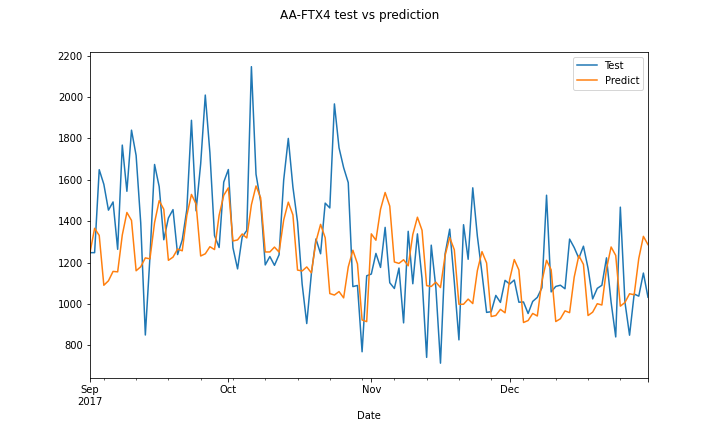

In [62]:
Image('AA_FTX4_test_pred.png')

In [ ]:
#view the plot of baseline vs forecast for 2018
pd.DataFrame({'baseline':baseline,'forecast':fore}).plot(figsize=(10, 6))
plt.suptitle('AA-FTX4 2018 baseline vs forecast')
plt.legend(["baseline", "forecast"])
plt.savefig('AA_FTX4_base_fore.png')

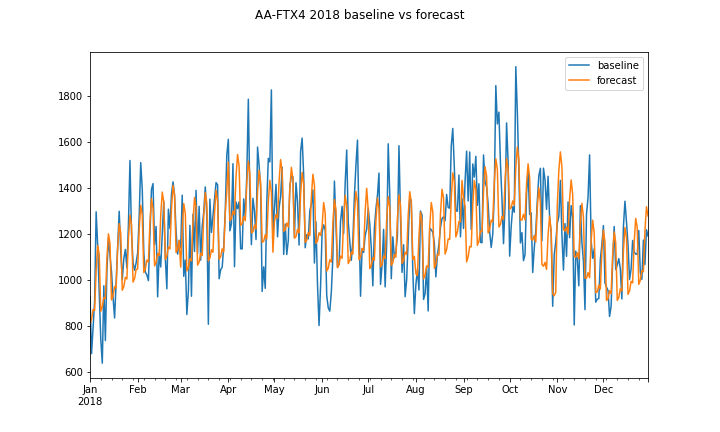

In [63]:
Image('AA_FTX4_base_fore.png')

In [ ]:
# now let's do FTX3, gotta re do the exog
exog = buf.copy()
#month one hot encoding
exog['month'] = exog.index.month
month_dummies = pd.get_dummies(exog['month'])
month_dummies.columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
exog = pd.concat([exog, month_dummies], axis=1).drop(['month'],axis=1)
#dayofweek one hot encoding
exog['dayofweek'] = exog.index.weekday
week_dummies = pd.get_dummies(exog['dayofweek'])
week_dummies.columns = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
exog = pd.concat([exog, week_dummies], axis=1).drop(['dayofweek'],axis=1)
exog = exog.drop(columns=['Daily'])
# prepare fourier terms
exog['sin364'] = np.sin(2 * np.pi * exog.index.dayofyear / 364)
exog['cos364'] = np.cos(2 * np.pi * exog.index.dayofyear / 364)
exog['sin364_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 364)
exog['cos364_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 364)
exog['sin364_3'] = np.sin(6 * np.pi * exog.index.dayofyear / 364)
exog['cos364_3'] = np.cos(6 * np.pi * exog.index.dayofyear / 364)
exog_to_train = exog[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',
                      'Mon','Tue','Wed','Thu','Fri','Sat','Sun',
                      'sin364','cos364','sin364_2','cos364_2','sin364_3','cos364_3']]['2016-01-04':'2017-08-31'].dropna()
exog_to_test = exog[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',
                     'Mon','Tue','Wed','Thu','Fri','Sat','Sun',
                     'sin364','cos364','sin364_2','cos364_2','sin364_3','cos364_3']]['2017-09-01':'2018-12-30'].dropna()
# auto_arima with m=7
AA_model = auto_arima(y=train, exogenous=exog_to_train, seasonal=True, m=7)
# Forecast
forecast = AA_model.predict(n_periods=486, exogenous=exog_to_test)
pred = forecast[:122]
fore = forecast[122:]
# plot test vs pred
pd.DataFrame({'test':test,'pred':pred}).plot(figsize=(10, 6))
plt.suptitle('AA-FTX3 test vs prediction')
plt.legend(["Test", "Predict"])
plt.savefig('AA_FTX3_test_pred.png')
plt.show()

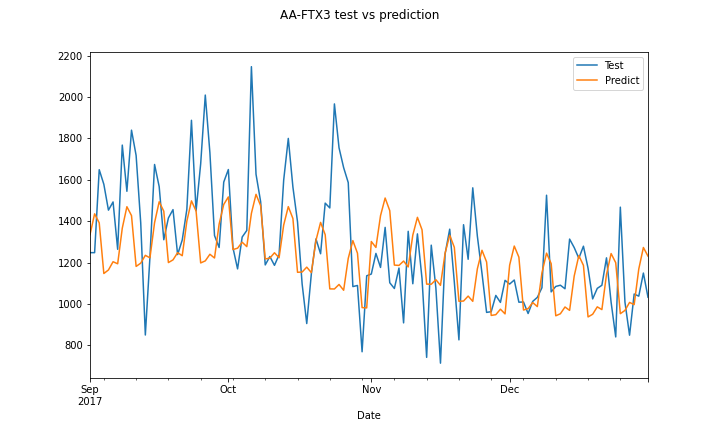

In [64]:
Image('AA_FTX3_test_pred.png')

In [ ]:
#view the plot of baseline vs forecast for 2018
pd.DataFrame({'baseline':baseline,'forecast':fore}).plot(figsize=(10, 6))
plt.suptitle('AA-FTX3 2018 baseline vs forecast')
plt.legend(["baseline", "forecast"])
plt.savefig('AA_FTX3_base_fore.png')
plt.show()

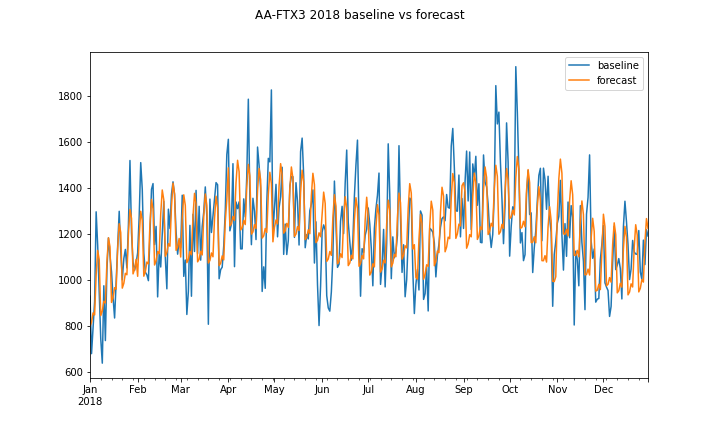

In [65]:
Image('AA_FTX3_base_fore.png')

In [ ]:
# we never had the plots for FTX 2 terms let's get it so we can compare the three
# redo the exog
exog = buf.copy()
#month one hot encoding
exog['month'] = exog.index.month
month_dummies = pd.get_dummies(exog['month'])
month_dummies.columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
exog = pd.concat([exog, month_dummies], axis=1).drop(['month'],axis=1)
#dayofweek one hot encoding
exog['dayofweek'] = exog.index.weekday
week_dummies = pd.get_dummies(exog['dayofweek'])
week_dummies.columns = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
exog = pd.concat([exog, week_dummies], axis=1).drop(['dayofweek'],axis=1)
exog = exog.drop(columns=['Daily'])
# prepare fourier terms
exog['sin364'] = np.sin(2 * np.pi * exog.index.dayofyear / 364)
exog['cos364'] = np.cos(2 * np.pi * exog.index.dayofyear / 364)
exog['sin364_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 364)
exog['cos364_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 364)
exog_to_train = exog[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',
                      'Mon','Tue','Wed','Thu','Fri','Sat','Sun',
                      'sin364','cos364','sin364_2','cos364_2']]['2016-01-04':'2017-08-31'].dropna()
exog_to_test = exog[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',
                     'Mon','Tue','Wed','Thu','Fri','Sat','Sun',
                     'sin364','cos364','sin364_2','cos364_2']]['2017-09-01':'2018-12-30'].dropna()
# auto_arima with m=7
AA_model = auto_arima(y=train, exogenous=exog_to_train, seasonal=True, m=7)
# Forecast
forecast = AA_model.predict(n_periods=486, exogenous=exog_to_test)
pred = forecast[:122]
fore = forecast[122:]
# plot test vs pred
pd.DataFrame({'test':test,'pred':pred}).plot(figsize=(10, 6))
plt.suptitle('AA-FTX2 test vs prediction')
plt.legend(["Test", "Predict"])
plt.savefig('AA_FTX2_test_pred.png')
plt.show()

In [ ]:
#view the plot of baseline vs forecast for 2018
pd.DataFrame({'baseline':baseline,'forecast':fore}).plot(figsize=(10, 6))
plt.suptitle('AA-FTX2 2018 baseline vs forecast')
plt.legend(["baseline", "forecast"])
plt.savefig('AA_FTX2_base_fore.png')
plt.show()

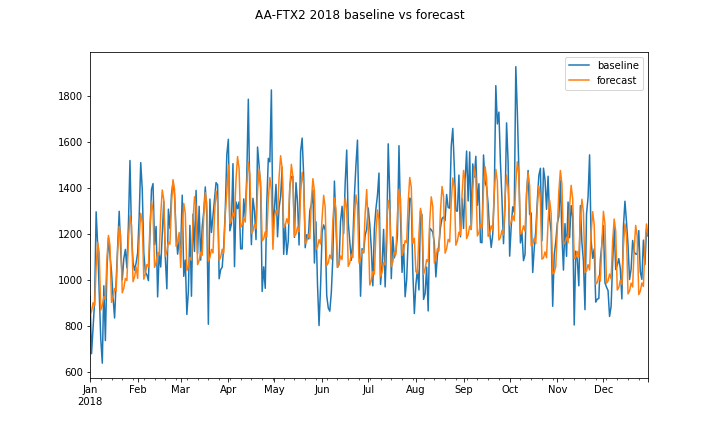

In [66]:
Image('AA_FTX2_base_fore.png')

In [67]:
# ARIMAX SARIMAX TBATS FTX were the models that captured the weekly periodicity and yearly seasonality
# let's get the scores of these models into a dataframe
tbats_df = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\TBATS.csv')
arimax_df = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\arimax_gridsearch.csv')
sarimax_df = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\sarimax_gridsearch.csv')
FTX_df = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\FTX_scores.csv')
model_score_dfs = pd.concat([tbats_df, arimax_df, sarimax_df, FTX_df], ignore_index=True)
display(model_score_dfs.model.unique()) #to check all models' names
model_score_dfs.columns # check the columns/scoring metrics and parameters

array(['TBATS', 'ARIMAX', 'SARIMAX', 'FTX 1 term', 'FTX 2 terms',
       'FTX 3 terms', 'FTX 4 terms'], dtype=object)

Index(['model', 'MSE', 'MAE', 'AIC', 'ForeMSE', 'ForeMAE', 'p', 'd', 'q', 'P',
       'D', 'Q'],
      dtype='object')

In [69]:
# let's view the top 3 of each scoring category
display(model_score_dfs.sort_values('MSE').head(3))
display(model_score_dfs.sort_values('ForeMSE').head(3))
display(model_score_dfs.sort_values('MAE').head(3))
display(model_score_dfs.sort_values('ForeMAE').head(3))
display(model_score_dfs.sort_values('AIC').head(3))

model           MSE         MAE          AIC       ForeMSE     ForeMAE  \
389  SARIMAX  65760.909437  193.471264  7939.056262  22704.976409  116.359742   
84    ARIMAX  65873.074606  193.495806  8029.195843  22576.327364  116.106628   
393  SARIMAX  65873.074606  193.495806  8029.195843  22576.327364  116.106628   

       p    d    q    P    D    Q  
389  5.0  0.0  2.0  1.0  0.0  0.0  
84   5.0  0.0  3.0  NaN  NaN  NaN  
393  5.0  0.0  3.0  0.0  0.0  0.0

model          MSE         MAE  AIC      ForeMSE     ForeMAE   p  \
452  FTX 4 terms  69428.45105  194.963525  NaN  21098.80627  112.940502 NaN   
451  FTX 3 terms  67322.72689  192.798886  NaN  21133.29324  112.767890 NaN   
450  FTX 2 terms  66073.42212  190.475741  NaN  21330.79498  113.681134 NaN   

      d   q   P   D   Q  
452 NaN NaN NaN NaN NaN  
451 NaN NaN NaN NaN NaN  
450 NaN NaN NaN NaN NaN

model           MSE         MAE          AIC       ForeMSE  \
450  FTX 2 terms  66073.422120  190.475741          NaN  21330.794980   
134      SARIMAX  65903.360646  191.998003  8076.731427  22572.938282   
449   FTX 1 term  65985.656540  192.208360          NaN  22569.104500   

        ForeMAE    p    d    q    P    D    Q  
450  113.681134  NaN  NaN  NaN  NaN  NaN  NaN  
134  116.913271  0.0  0.0  0.0  1.0  0.0  1.0  
449  116.964918  NaN  NaN  NaN  NaN  NaN  NaN

model          MSE         MAE  AIC      ForeMSE     ForeMAE   p  \
451  FTX 3 terms  67322.72689  192.798886  NaN  21133.29324  112.767890 NaN   
452  FTX 4 terms  69428.45105  194.963525  NaN  21098.80627  112.940502 NaN   
450  FTX 2 terms  66073.42212  190.475741  NaN  21330.79498  113.681134 NaN   

      d   q   P   D   Q  
451 NaN NaN NaN NaN NaN  
452 NaN NaN NaN NaN NaN  
450 NaN NaN NaN NaN NaN

model           MSE         MAE          AIC      ForeMSE     ForeMAE  \
164  SARIMAX  75122.850407  205.571820  7872.071180  24781.53207  122.329828   
168  SARIMAX  75991.919826  207.810908  7876.046133  25233.44067  123.115089   
376  SARIMAX  78656.194975  211.653774  7876.067544  26353.48794  126.525692   

       p    d    q    P    D    Q  
164  0.0  0.0  4.0  0.0  1.0  1.0  
168  0.0  0.0  4.0  1.0  1.0  1.0  
376  5.0  0.0  0.0  1.0  1.0  1.0

Let's do reduction reasoning
1st to reject is best AIC models, they have best AIC scores but their MSE/ForeMSE scores are terrible, so let's take a look at the other 4 metric scoring.

It appears that FTX2 terms has the best over all results. MSE of 66073 is only 200 away from top MSE socre, while FTX 2 terms' ForeMSE and ForeMAE scores are much better than SARIMAX ARIMAX models (ForeMSE by at least 1200). FTX 3 terms have slight better ForeMAE score, while ARIMAX & SARIMAX 503 000 are same, so let's take a look at these 3 models

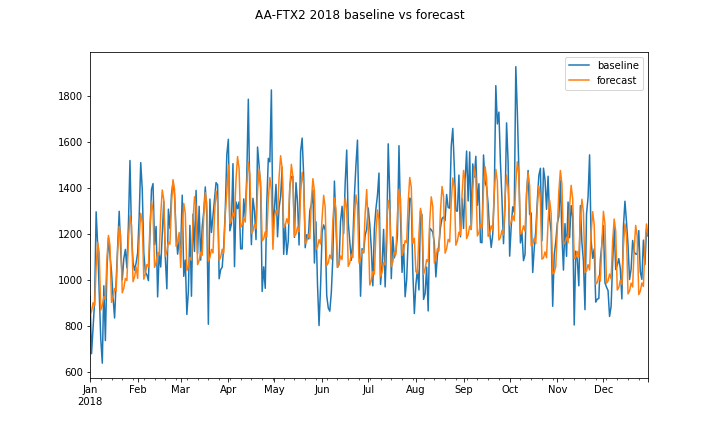

In [70]:
Image('AA_FTX2_base_fore.png') 

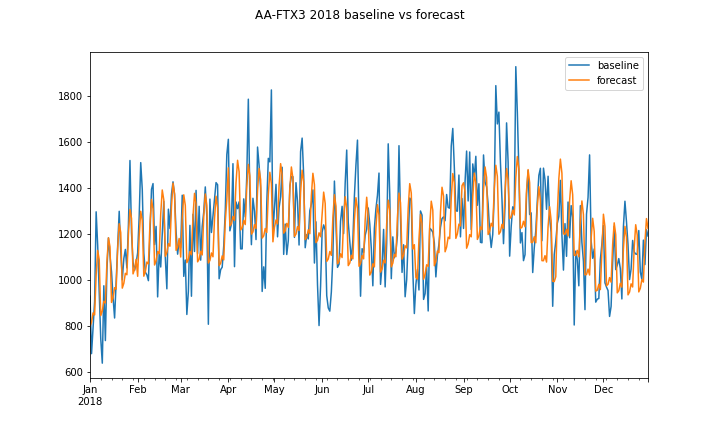

In [71]:
Image('AA_FTX3_base_fore.png')

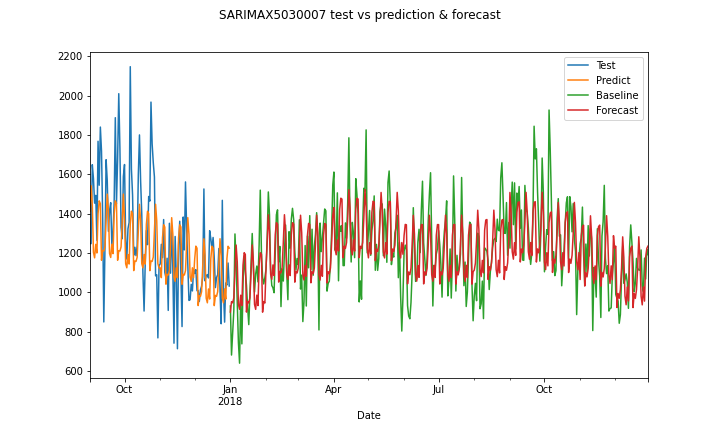

In [75]:
Image('sarimax5030007_test_pred.png')

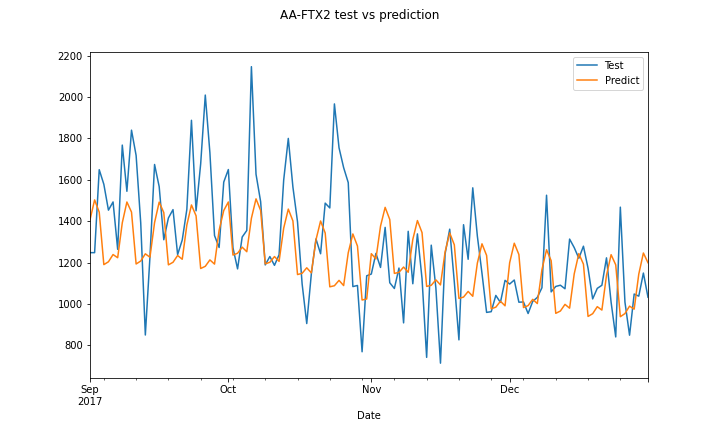

In [76]:
Image('AA_FTX2_test_pred.png')

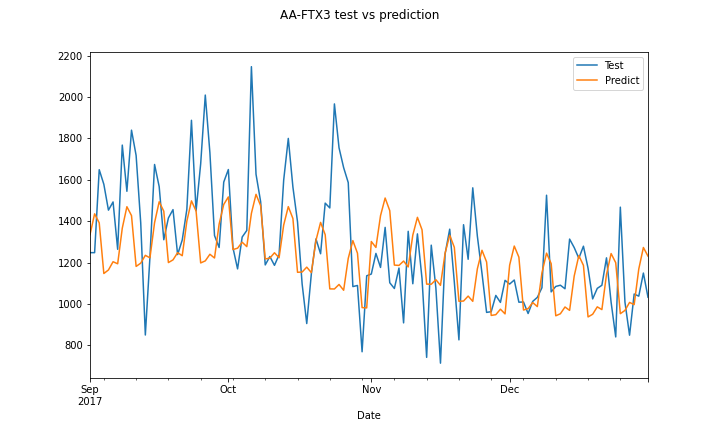

In [77]:
Image('AA_FTX3_test_pred.png')

It's very hard to differentiate the FTX models of them, but given the similar results, it'd save a lot of time to just have 2 terms instead of 3! SARIMAX might not have the wave form like FTX model but its prediciton power is still very good.

The best model with the given daily data will be
auto_arima with fourier term (2), day of week, and month as its exogenous variables (decided by metric score, since all three models above were able to capture weekly and yearly seasonality).